In [1]:
import os
os.environ["SPARK_HOME"] = "/home/hadoop/spark"

import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext(appName = "tomato")

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

24/06/10 18:29:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date
import os

# 새로운 SparkSession 생성
spark = SparkSession.builder \
    .appName("Tomato Data Analysis") \
    .getOrCreate()

# 파일 경로 설정
file_path = "/home/hadoop/bigdata_project/test_merge_tomato_data.csv/part-00000-6fe08533-7d31-4459-a9a1-2a81375fa6ad-c000.csv"

# CSV 파일 불러오기
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 날짜 부분만 추출
df_with_date = df.withColumn("date", to_date(col("MSRM_DT"), "yyyy-MM-dd"))

# 열 이름 수집 (MSRM_DT와 date를 제외한 열들)
columns = [col for col in df.columns if col != "MSRM_DT"]

# 날짜별 그룹화하여 평균 계산 (null 값을 제외하고 평균 계산)
agg_exprs = [F.mean(col).alias(col) for col in columns]

# 날짜별 그룹화 및 평균 계산
average_df = df_with_date.groupBy("date").agg(*agg_exprs)
average_df_sorted = average_df.orderBy("date")

# 절대 경로로 저장 경로 설정
output_path = "/home/hadoop/bigdata_project/daily_avg_tomato_data"

# 통합된 데이터 저장
output_file = os.path.join(output_path, "daily_avg_tomato_data.csv")
average_df_sorted.coalesce(1).write.csv(output_file, header=True, mode='overwrite')


24/06/06 19:54:05 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


In [3]:
import pandas as pd

# 파일 경로 설정
file_path = "/home/hadoop/bigdata_project/daily_avg_tomato_data/daily_avg_tomato_data.csv/part-00000-9ad0dc1a-a05f-44f2-8323-573ed764fb6f-c000.csv"

# pandas를 사용하여 CSV 파일 불러오기
df = pd.read_csv(file_path)

# 상위 5개 행 출력
df.head()


date  ABSLT_HMDT  INNER_TPRT_1  FRST_CLUSTER  CLR_OPRT_YN_2  \
0  2022-10-07   13.789697     21.755455           NaN            0.0   
1  2022-10-08   12.718576     20.255208           NaN            0.0   
2  2022-10-09   14.920139     19.863194           NaN            0.0   
3  2022-10-10   12.748437     19.002257           NaN            0.0   
4  2022-10-11   12.304167     19.358507           NaN            0.0   

   SPRYN_DEVICE  FRST_TREE_CNT  TRWVLV_OPDR_RATE_2  SKLT_OPMD_2_LEFT  \
0      0.060606            NaN          100.000000               0.0   
1      0.059028            NaN           77.430556               0.0   
2      0.000000            NaN           65.460069               0.0   
3      0.138889            NaN           56.482639               0.0   
4      0.083333            NaN           61.159722               0.0   

   SKLT_OPMD_1_LEFT  ...  LEAF_LNGTH  RTTN_PUMP_OPRT_YN_2  PLT_LNGTH  \
0          1.000000  ...       420.1                  0.0    1061.92   
1          1.000000  ...       420.1                  0.0    1061.92   
2          0.989583  ...       420.1                  0.0    1061.92   
3          1.000000  ...       420.1                  0.0    1061.92   
4          1.000000  ...       420.1                  0.0    1061.92   

   CLR_OPRT_YN_3  HRZNT_SCRN_OPDR_RATE_2  TRWVLV_OPMD_1  FMGEQ_OPRT_YN  \
0            0.0               99.533333            0.0            0.0   
1            0.0               99.916667            0.0            0.0   
2            0.0              100.000000            0.0            0.0   
3            0.0              100.000000            0.0            0.0   
4            0.0              100.000000            0.0            0.0   

   INNER_HMDT_1  NTSLT_SPL_ELCDT  CBDX_GNRT_OPMD  
0     70.380606         3.363636             0.0  
1     71.888368         3.258333             0.0  
2     85.157813         3.279167             0.0  
3     77.963715         3.050000             0.0  
4     73.693576         2.970833             0.0  

[5 rows x 89 columns]

In [2]:
from pyspark.sql import SparkSession
import pandas as pd

# 새로운 SparkSession 생성
spark = SparkSession.builder \
    .appName("Gaussian Analysis") \
    .getOrCreate()

# 파일 경로 설정
file_path = "/home/hadoop/bigdata_project/daily_avg_tomato_data/daily_avg_tomato_data.csv/part-00000-9ad0dc1a-a05f-44f2-8323-573ed764fb6f-c000.csv"

# CSV 파일 불러오기
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 데이터프레임을 pandas 데이터프레임으로 변환
pdf = df.toPandas()


24/06/10 18:29:36 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


In [3]:
# 모든 값이 null인 열 확인 및 제거
pdf = pdf.dropna(axis=1, how='all')

# 각 열의 평균과 표준 편차 계산
stats = pdf.describe().transpose()
means = stats['mean']
std_devs = stats['std']


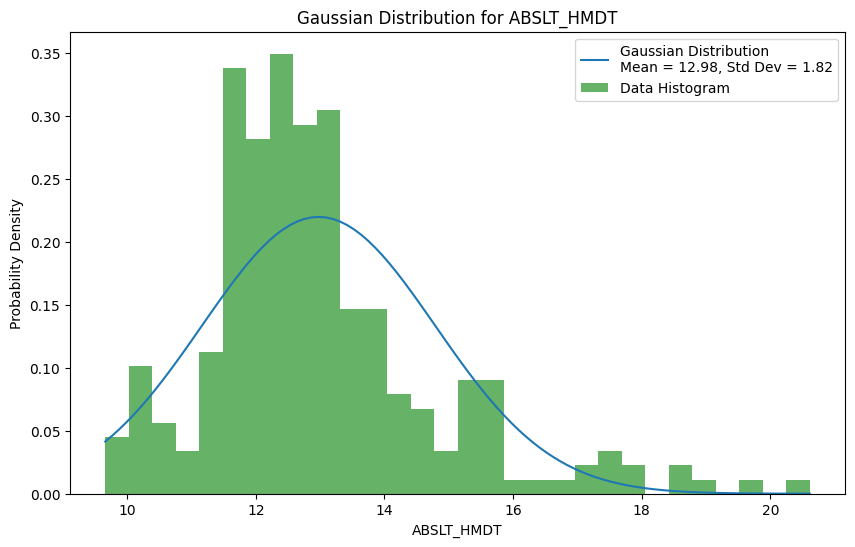

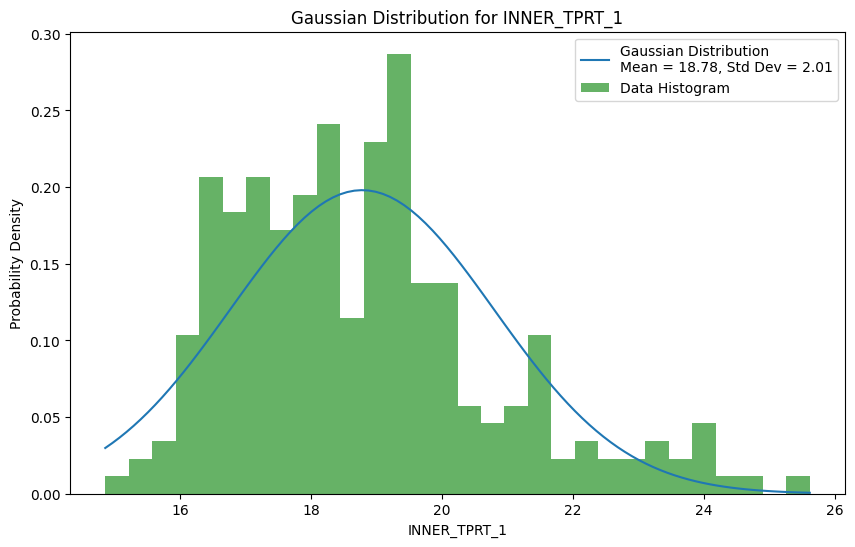

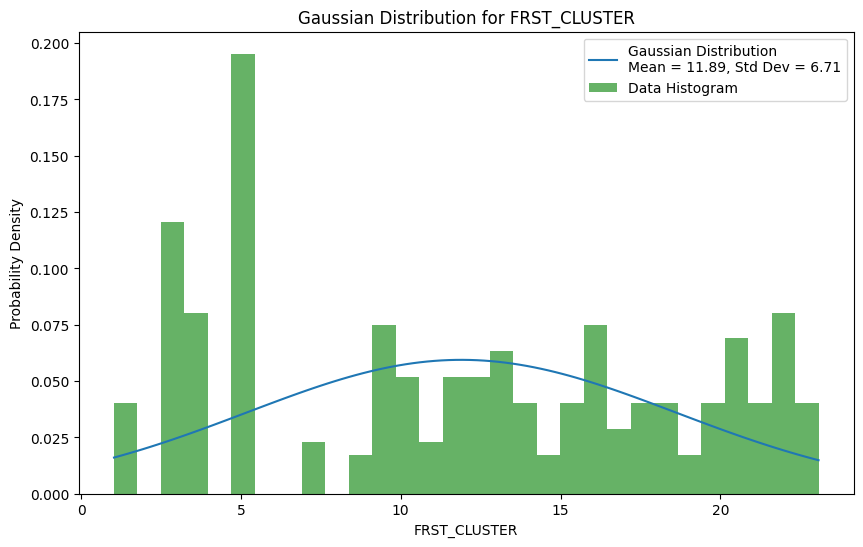

/home/hadoop/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/hadoop/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


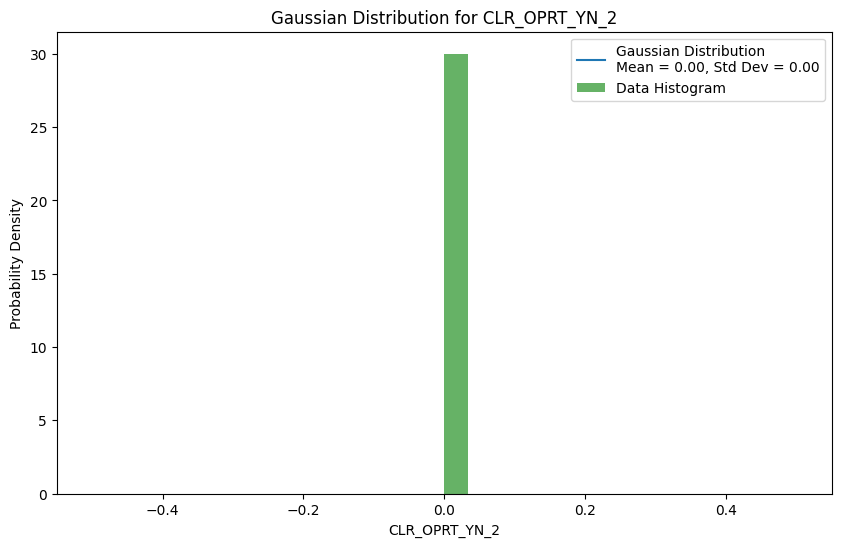

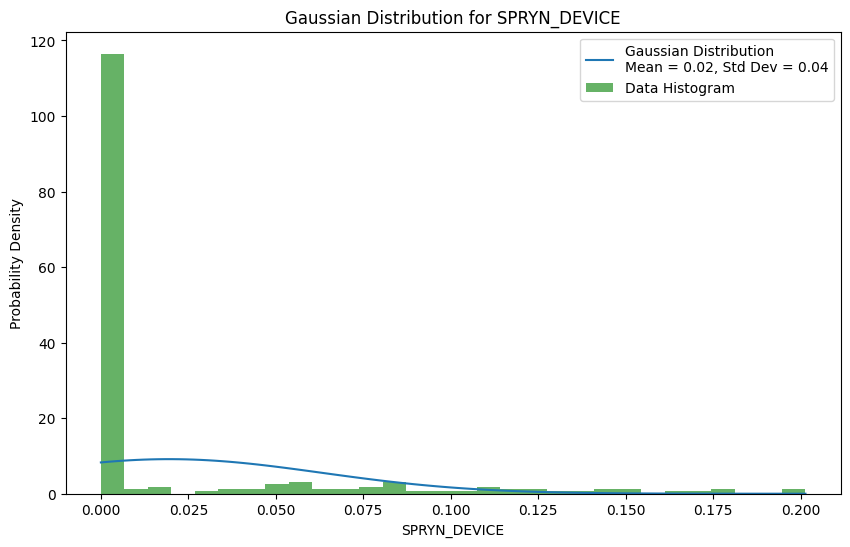

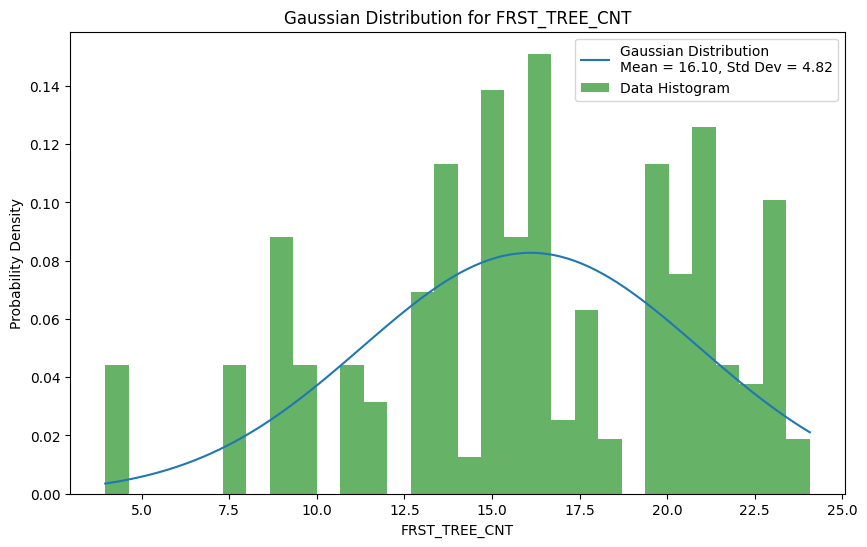

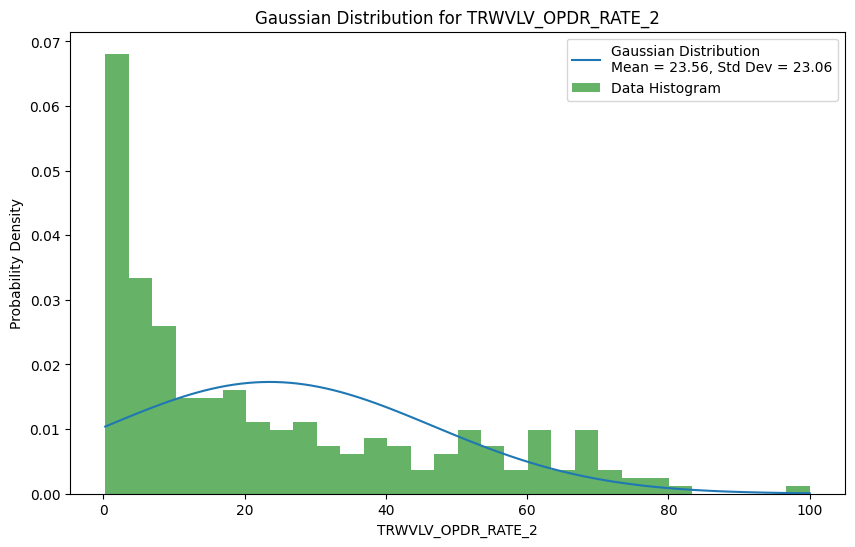

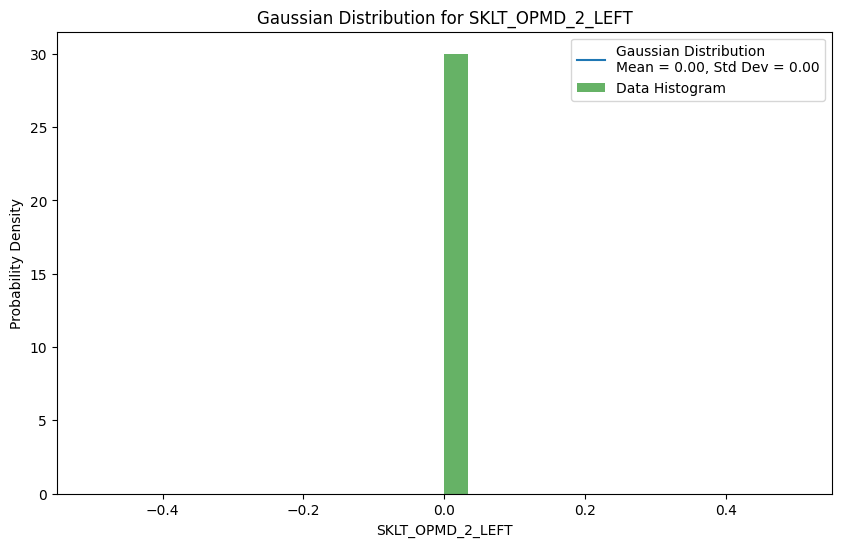

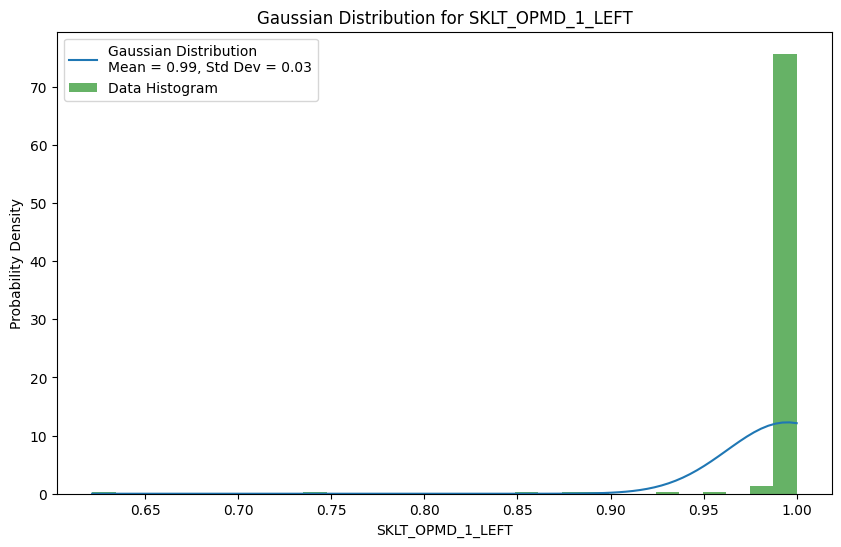

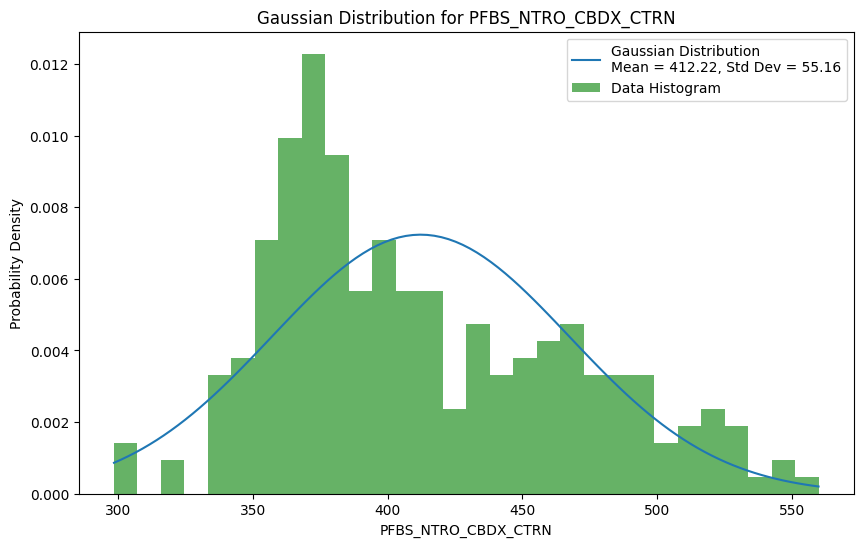

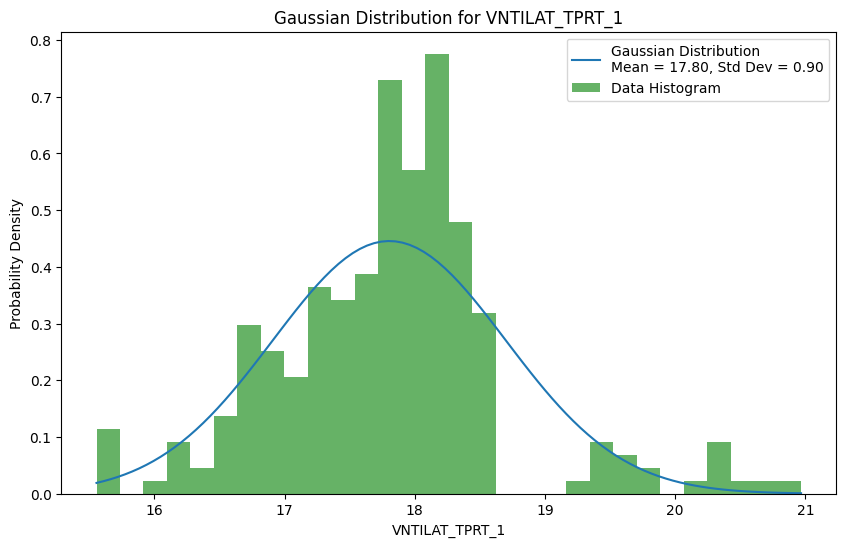

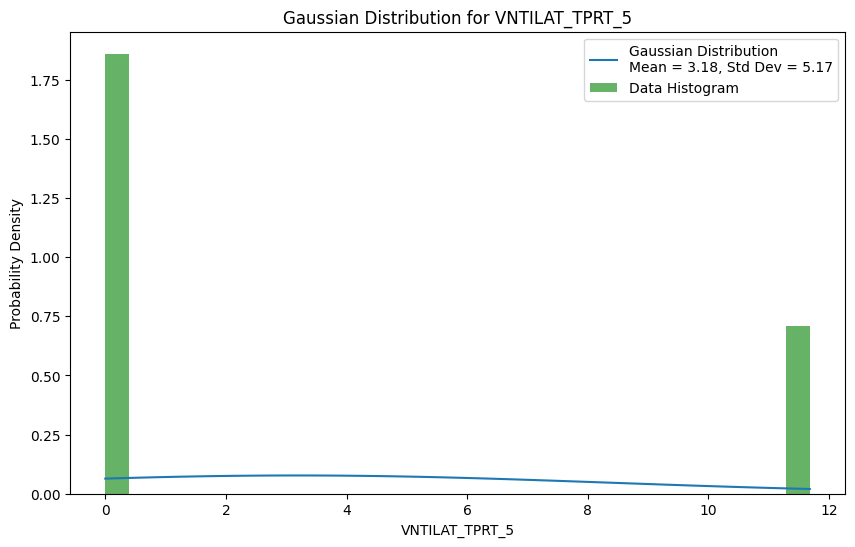

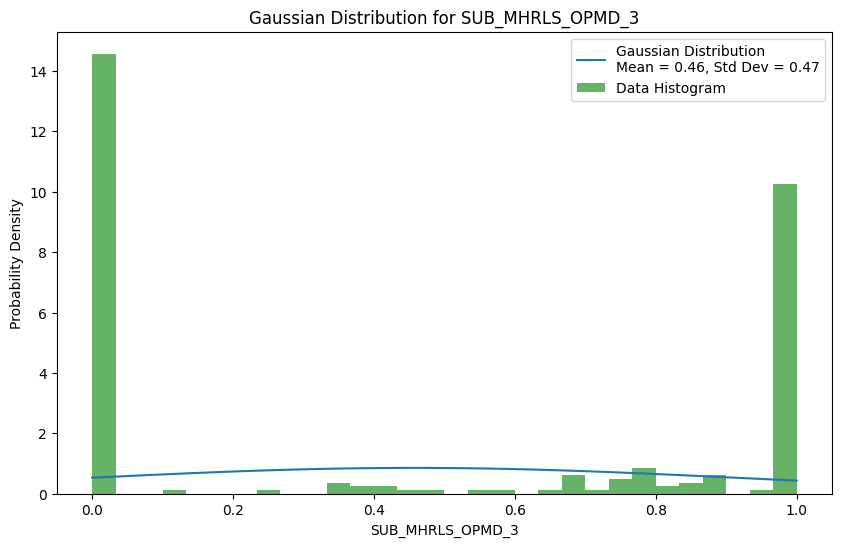

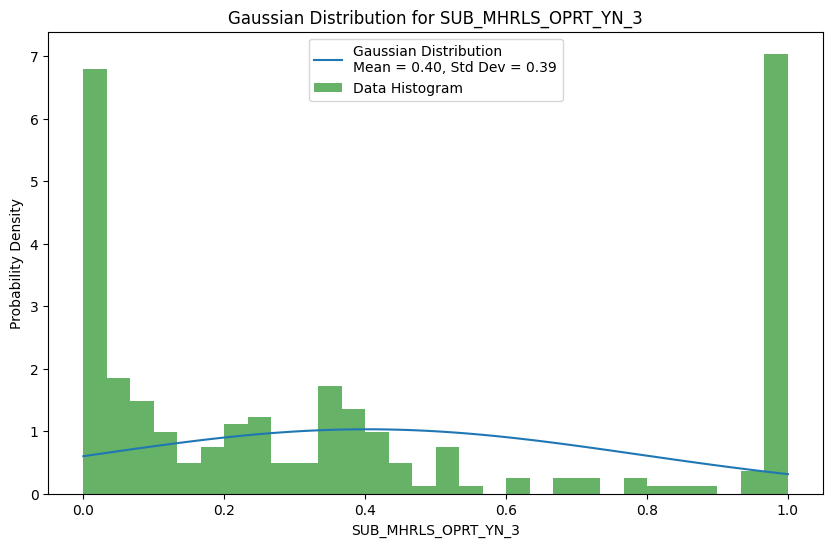

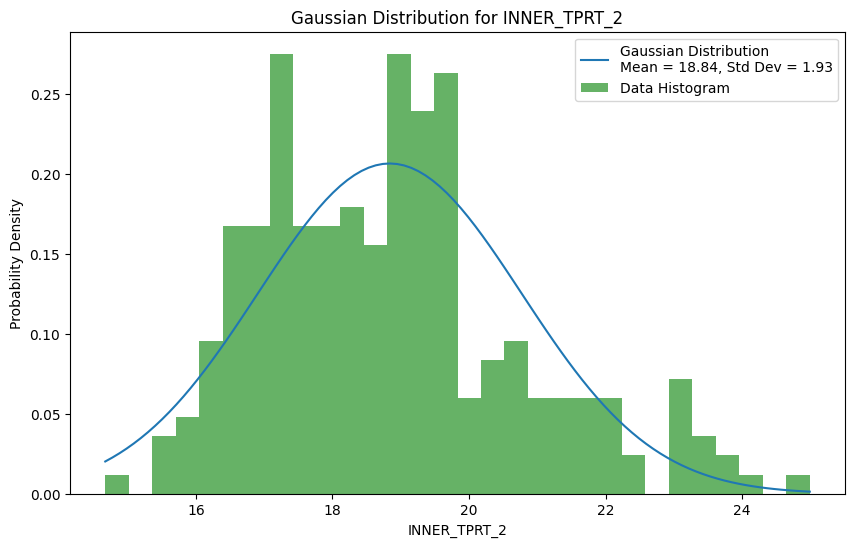

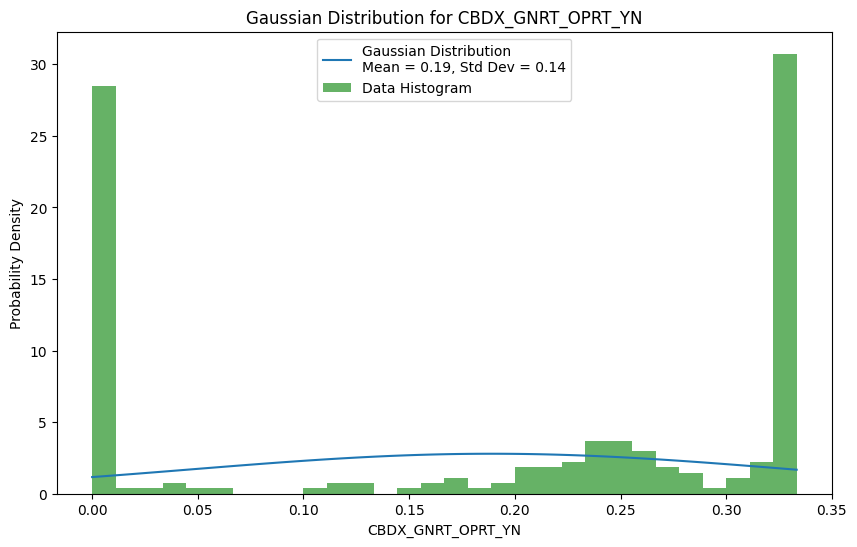

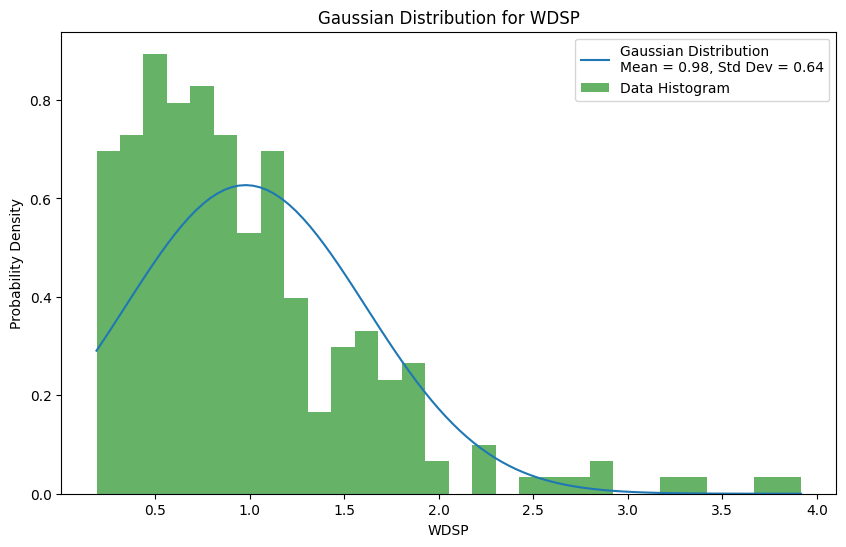

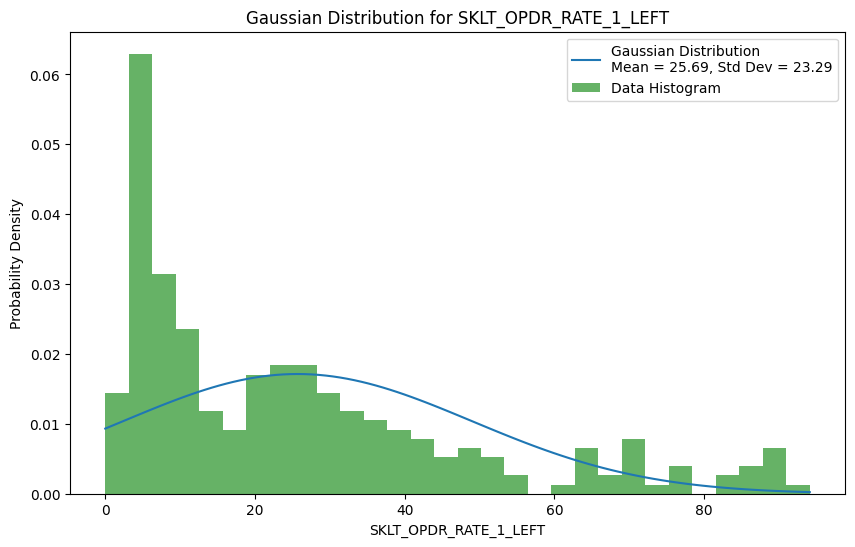

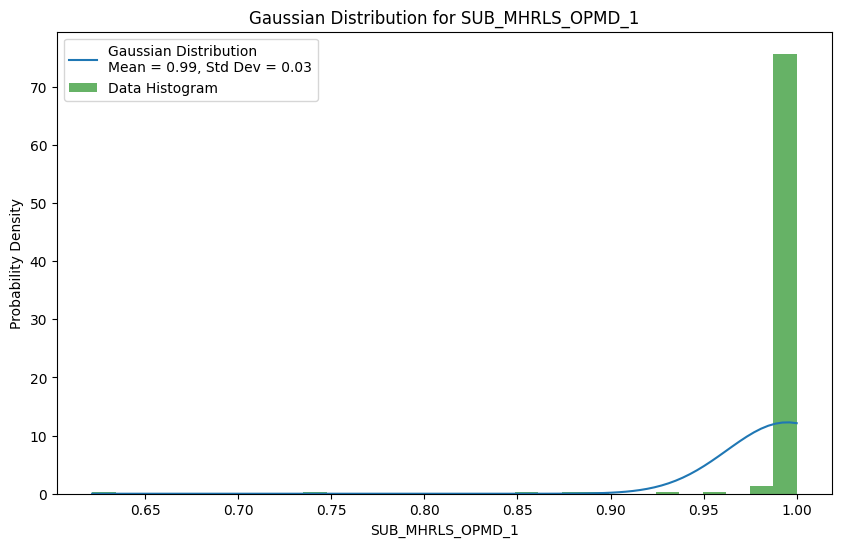

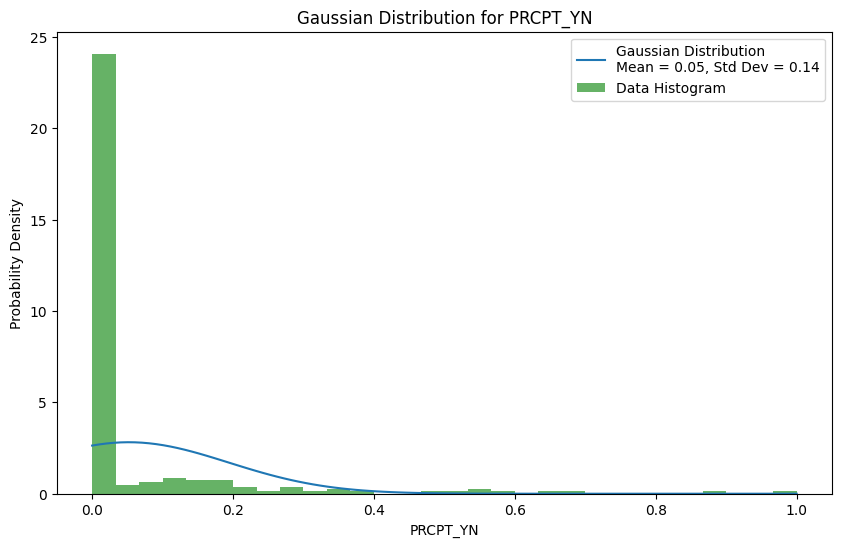

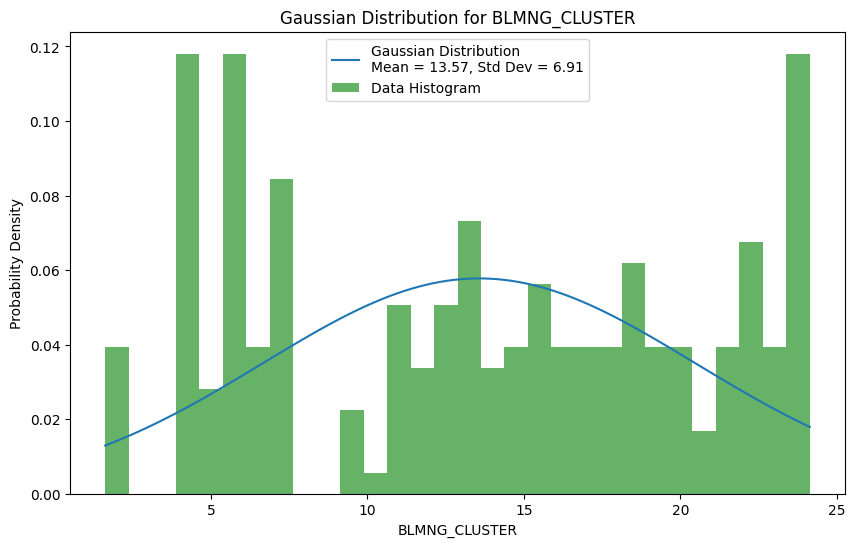

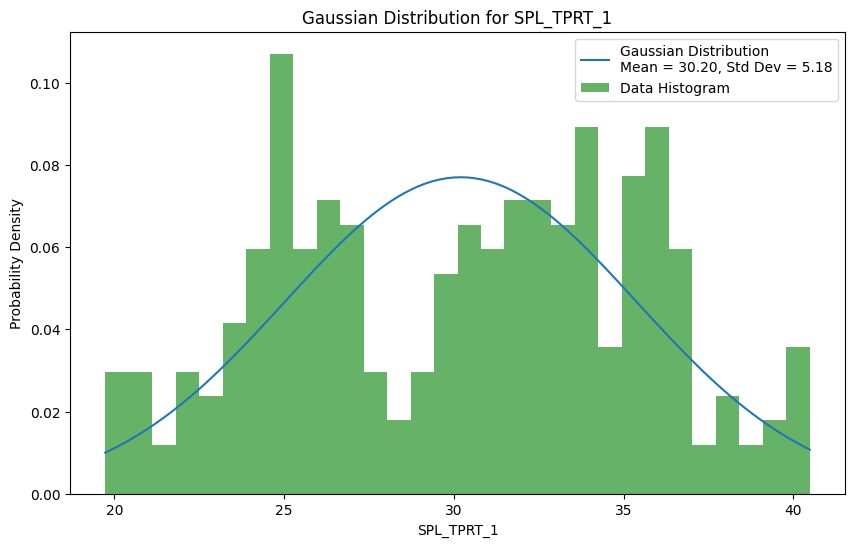

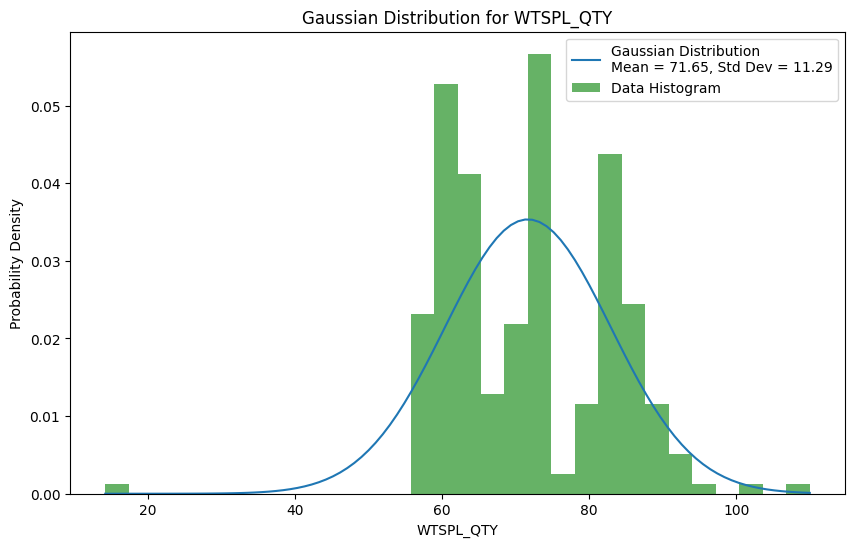

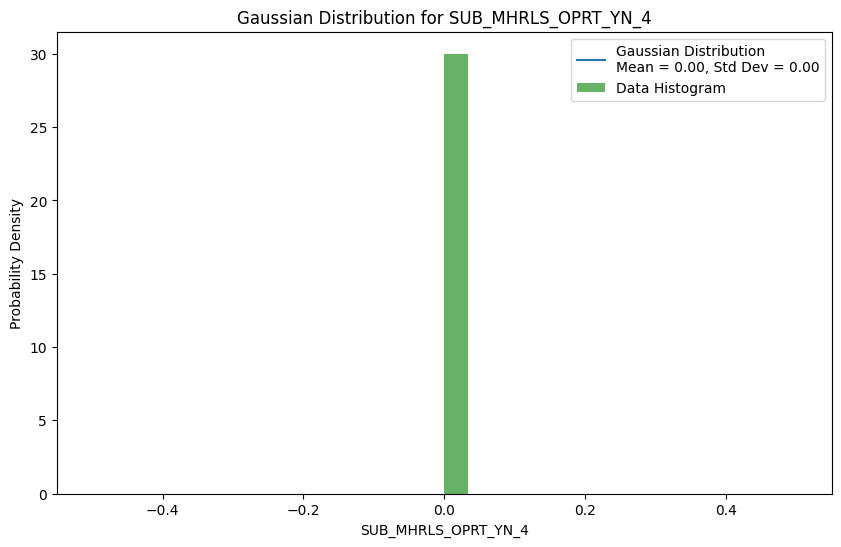

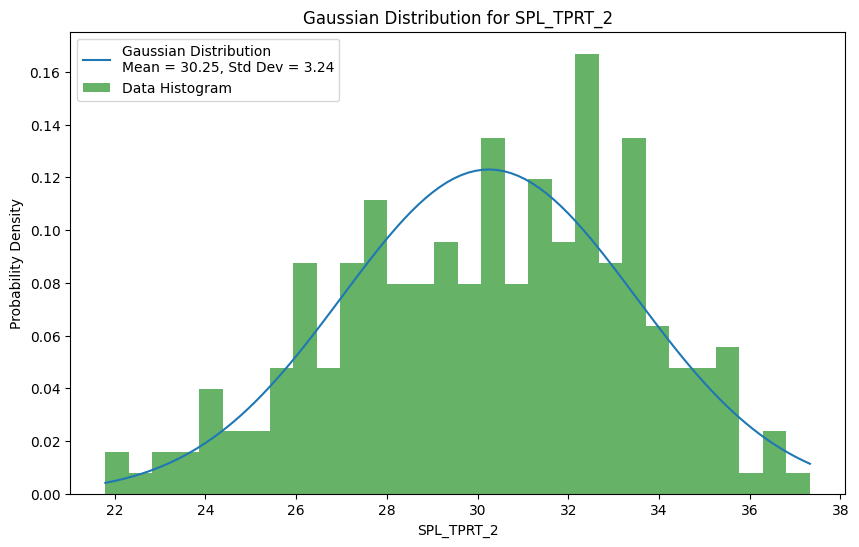

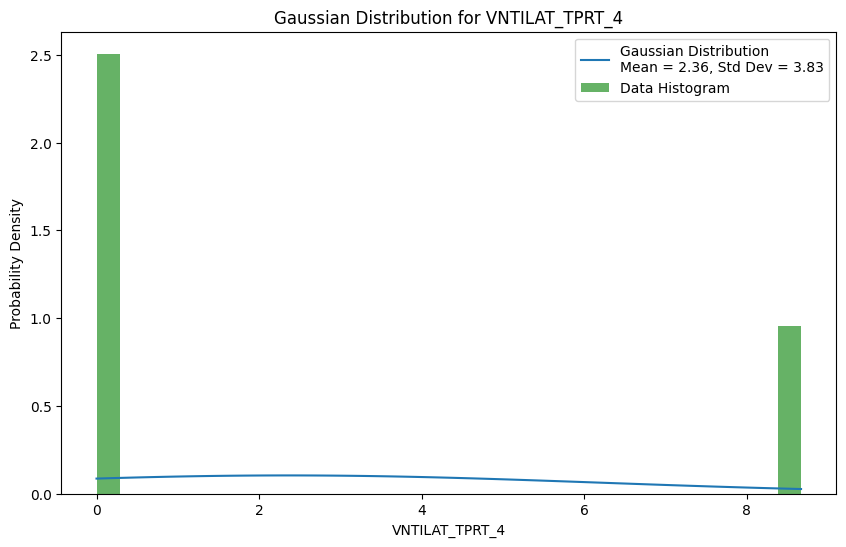

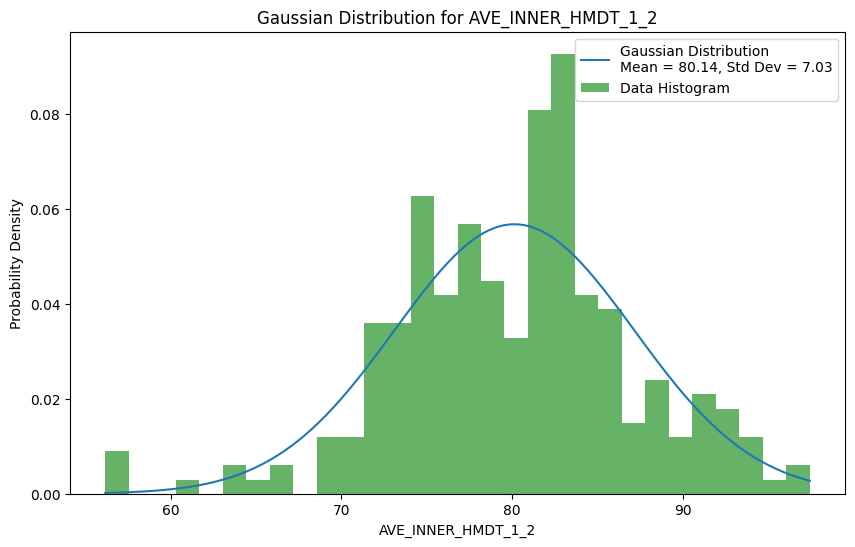

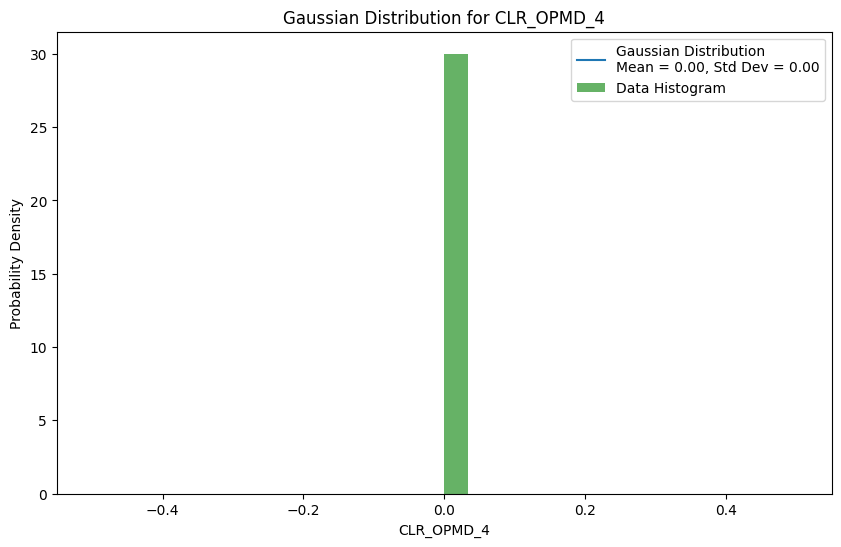

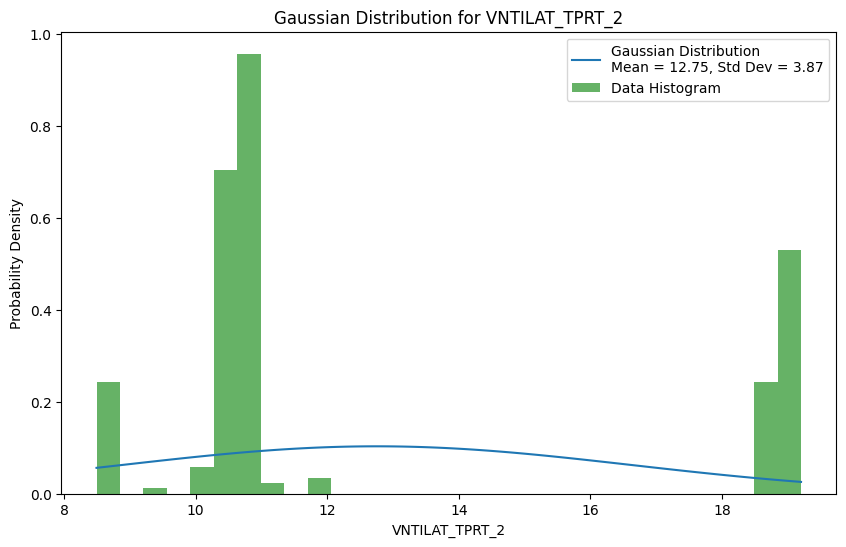

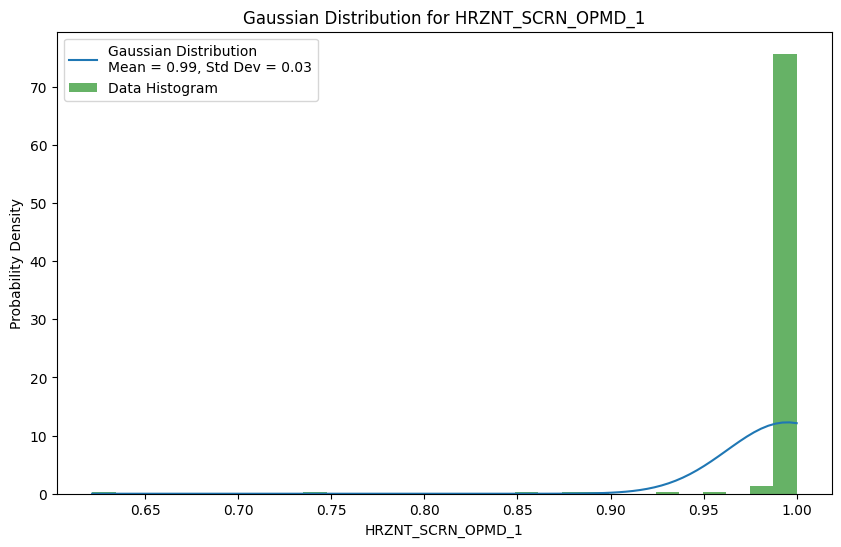

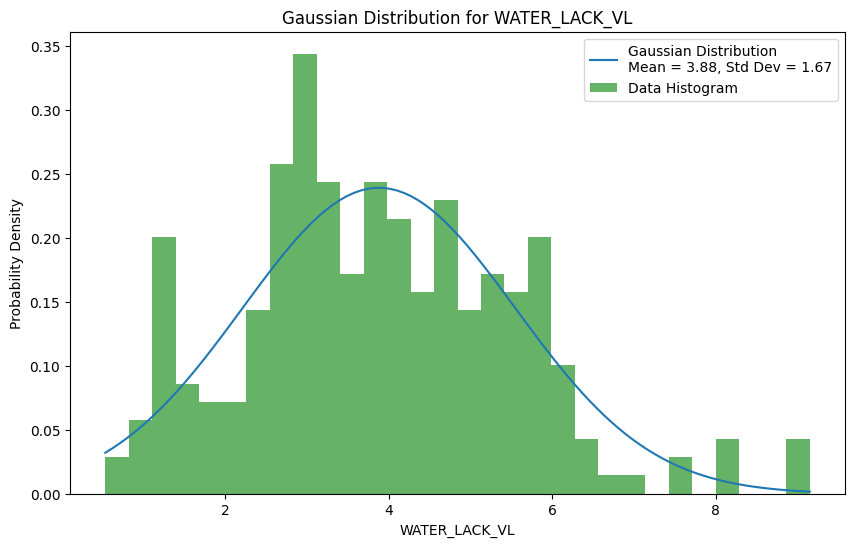

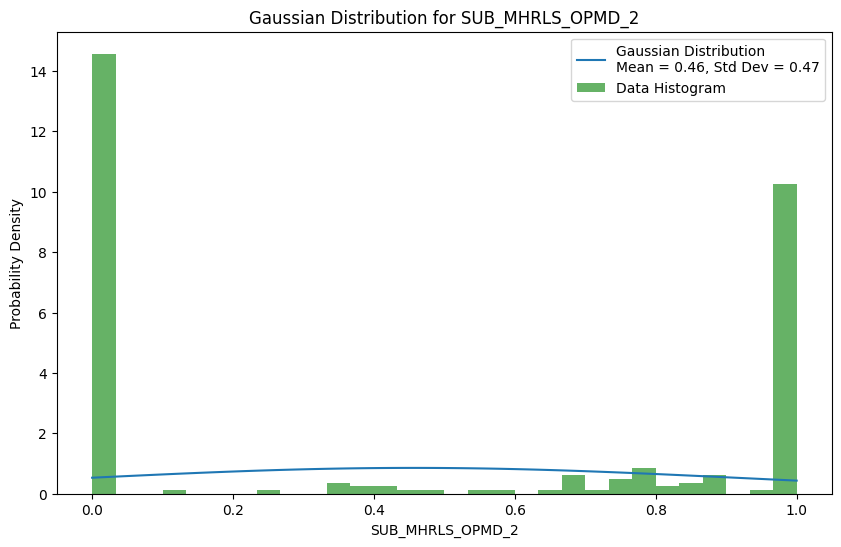

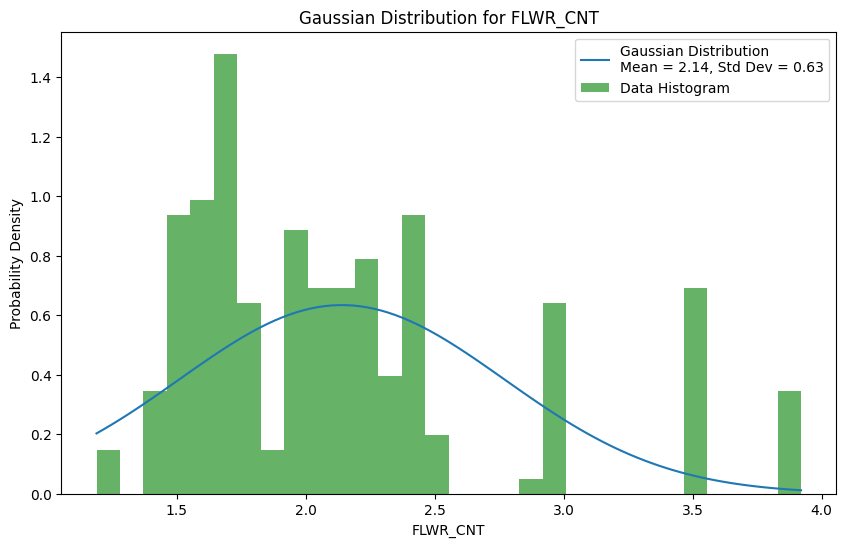

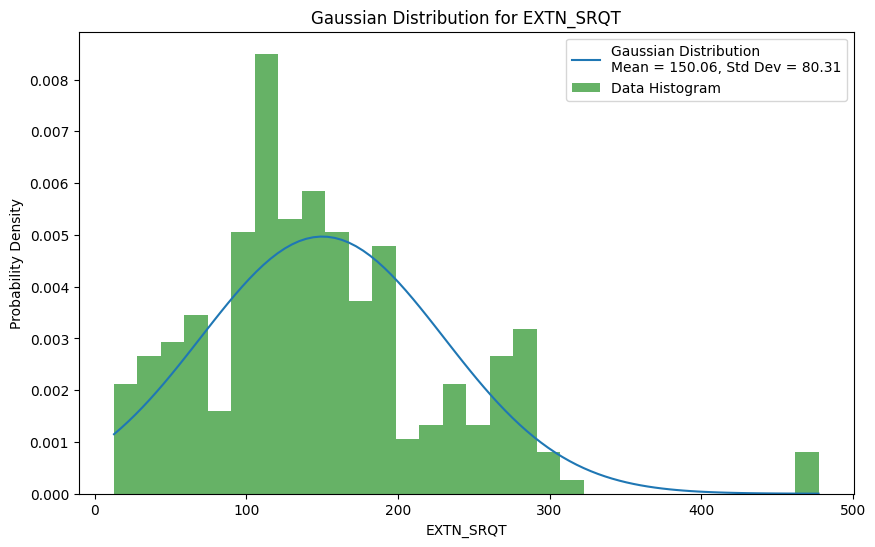

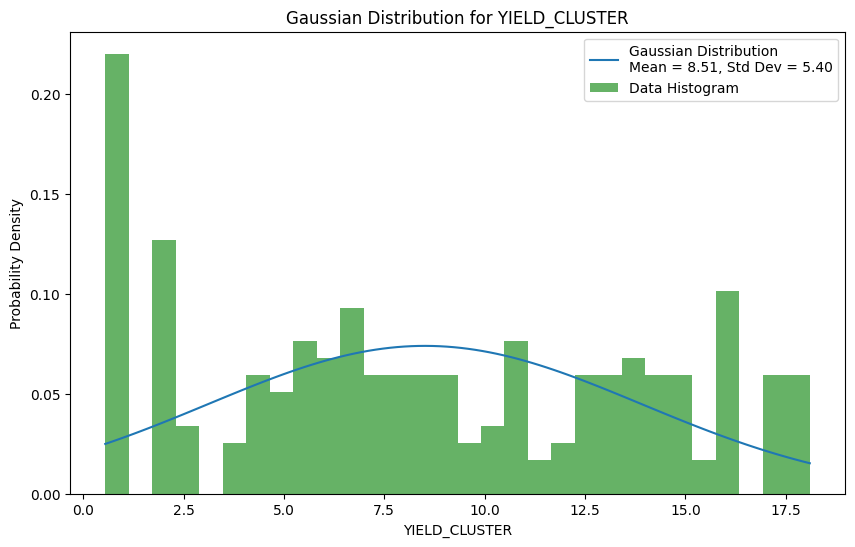

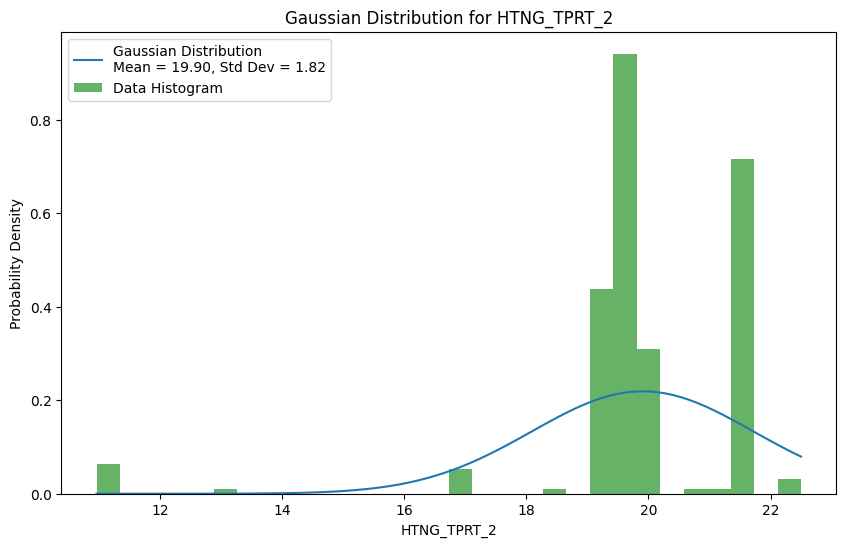

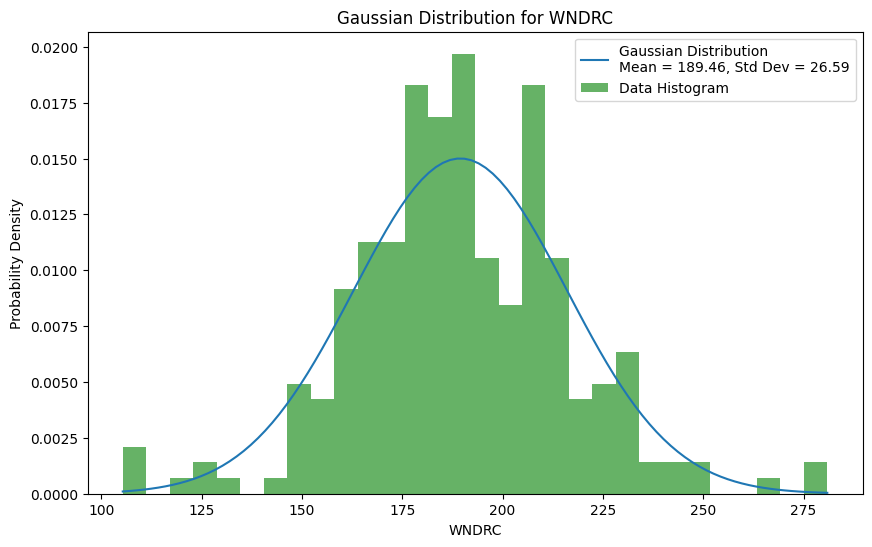

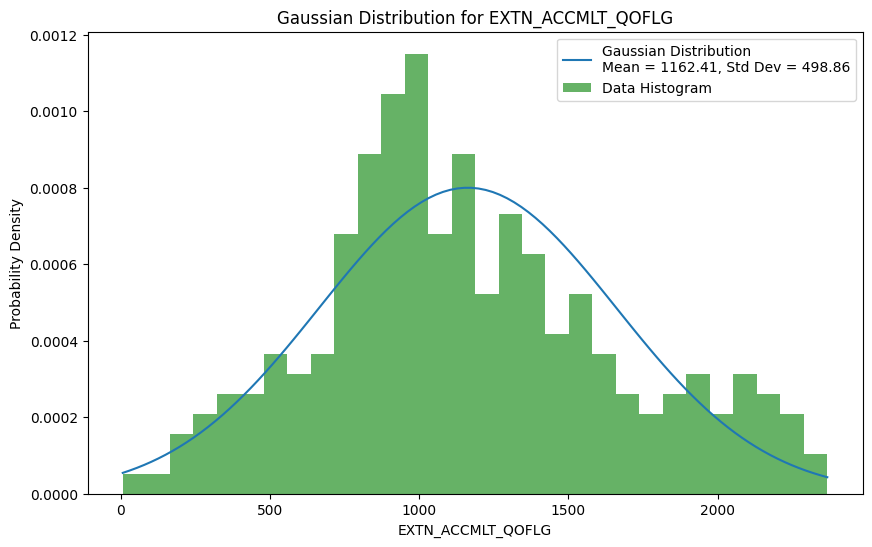

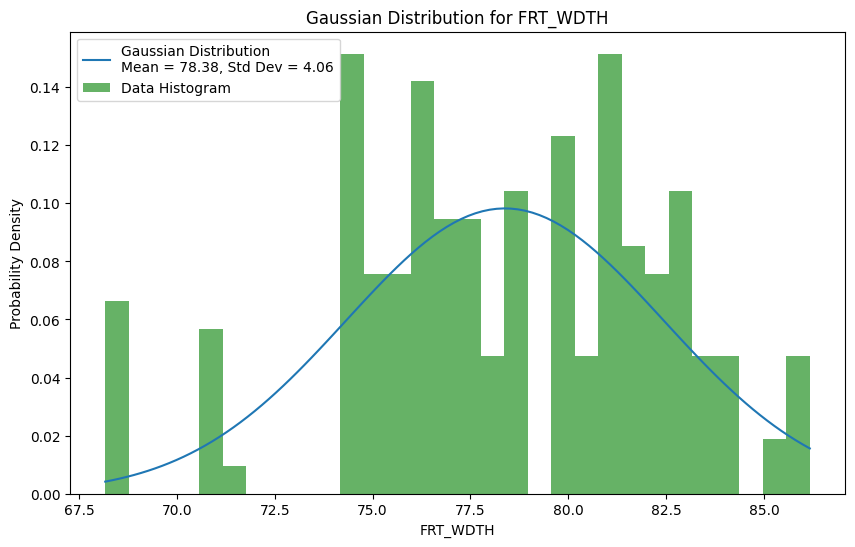

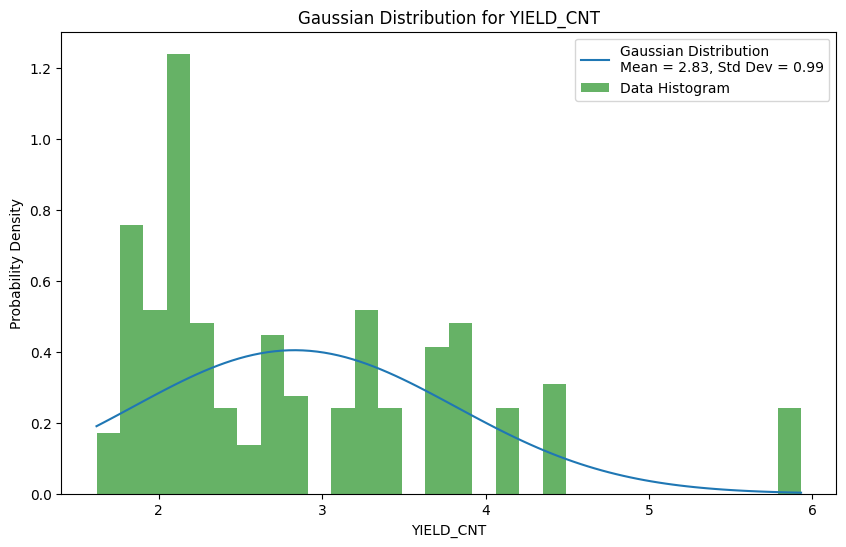

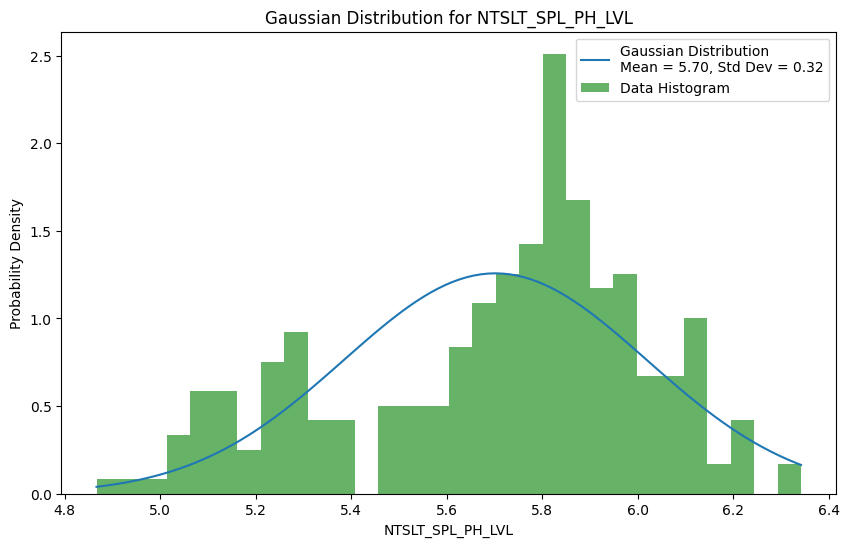

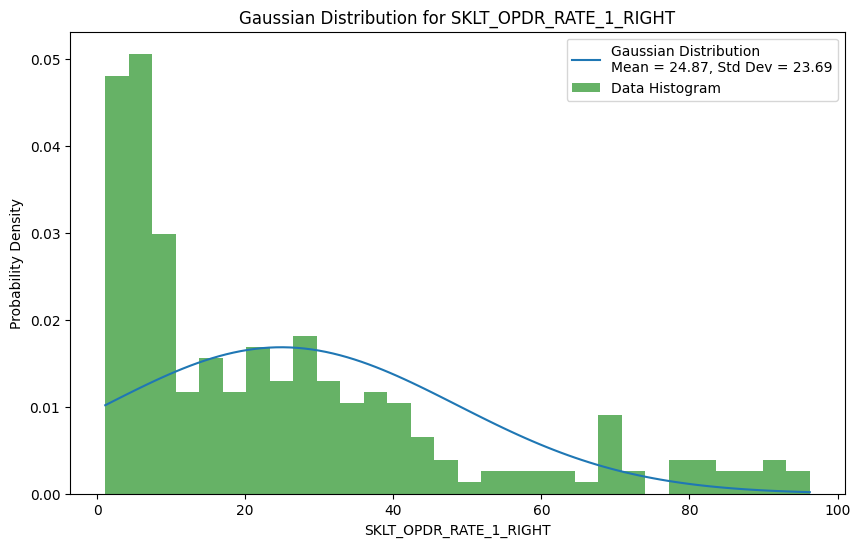

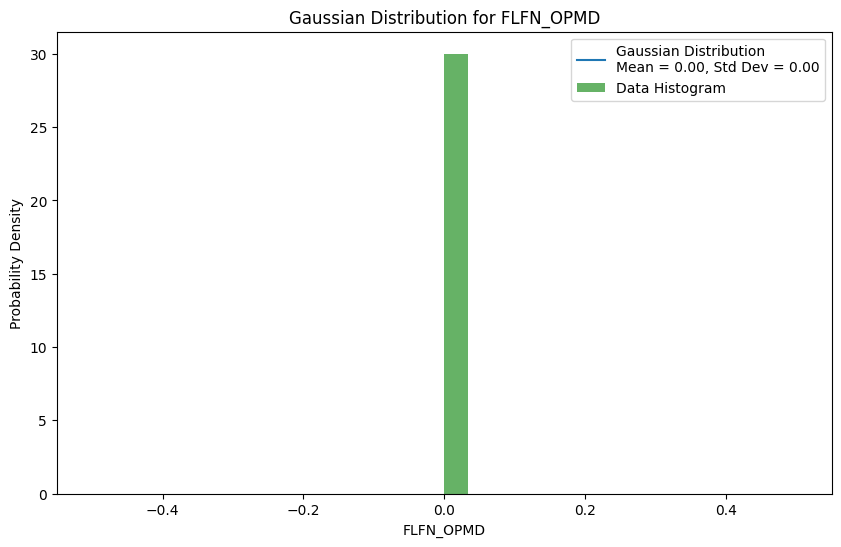

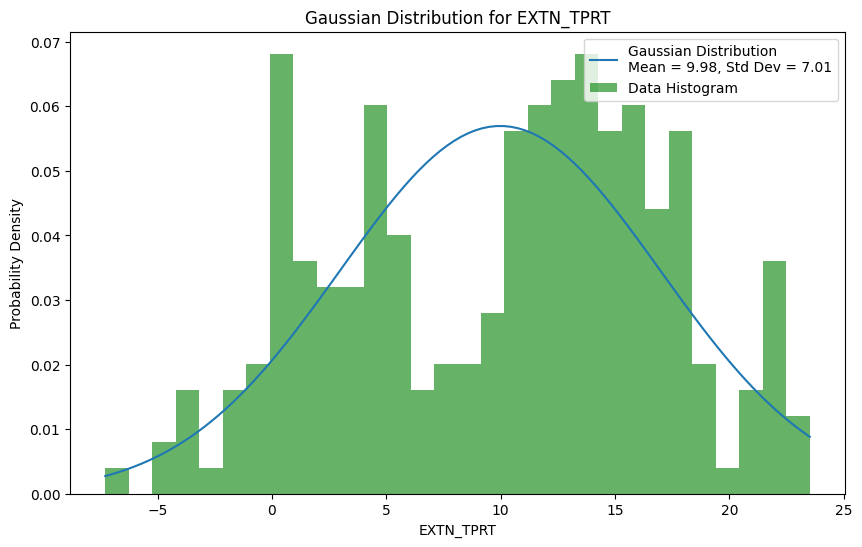

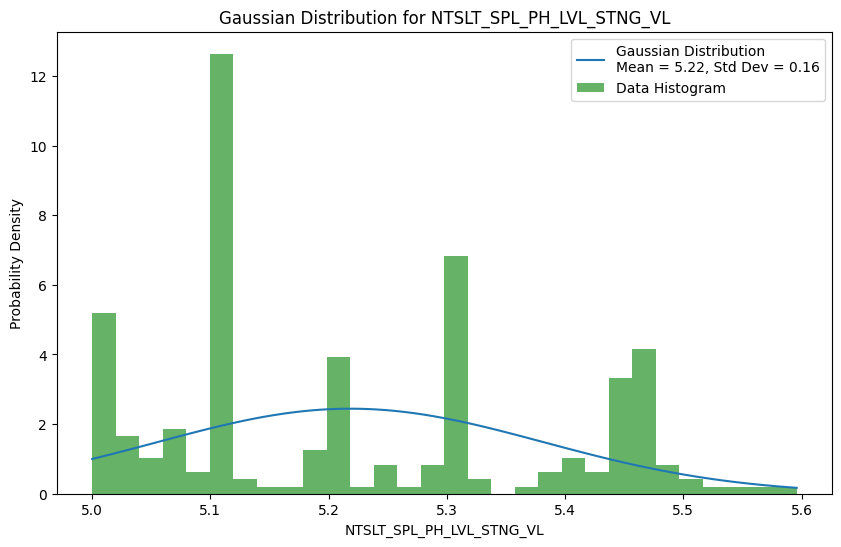

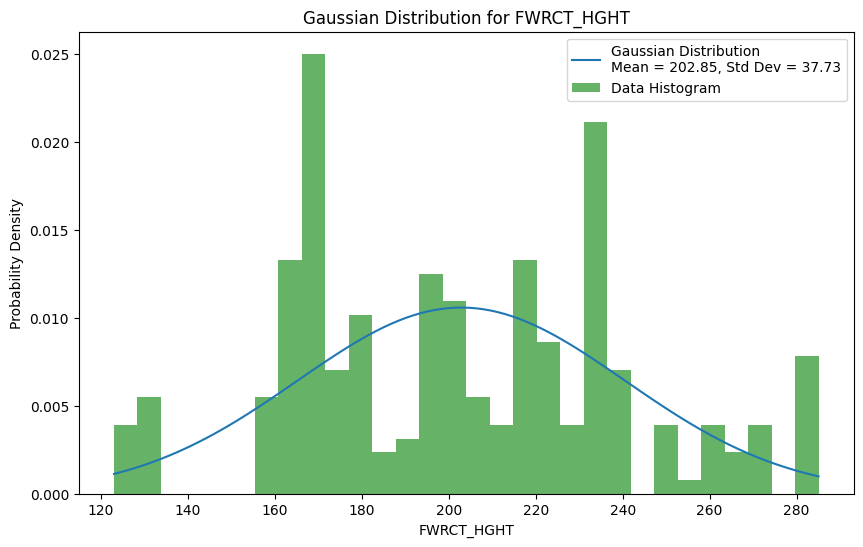

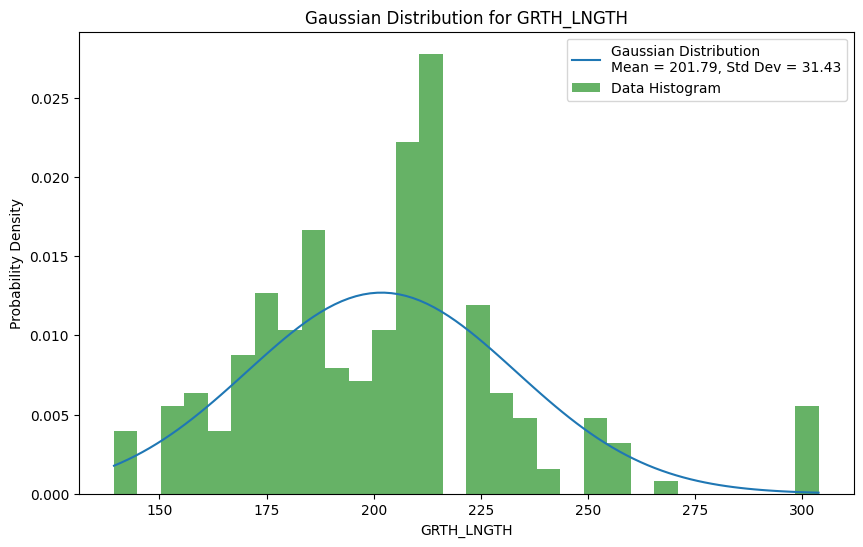

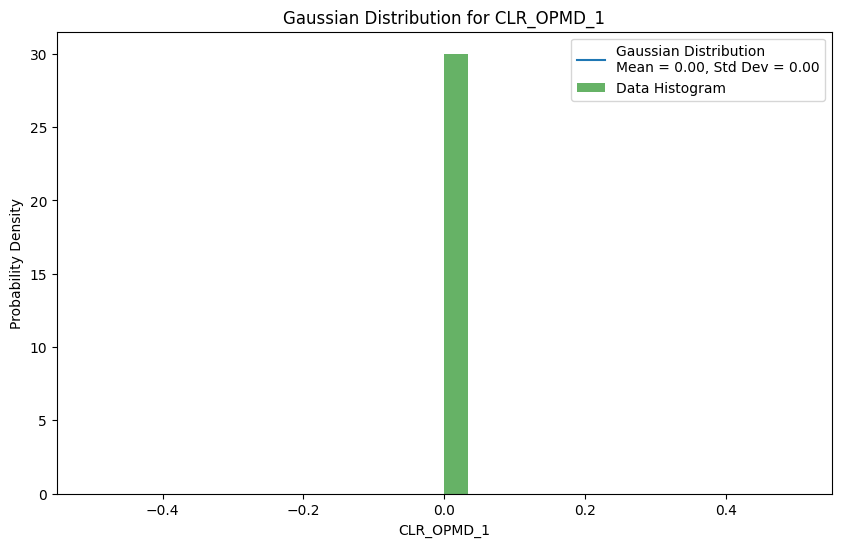

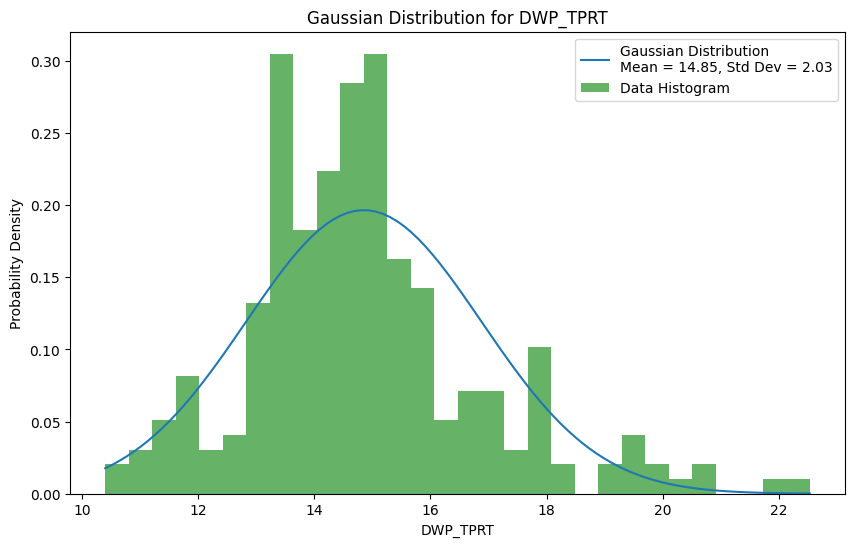

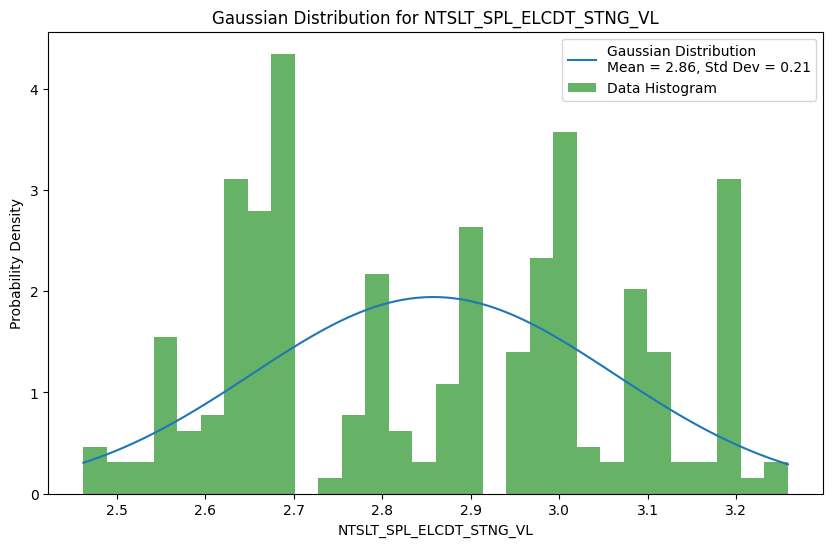

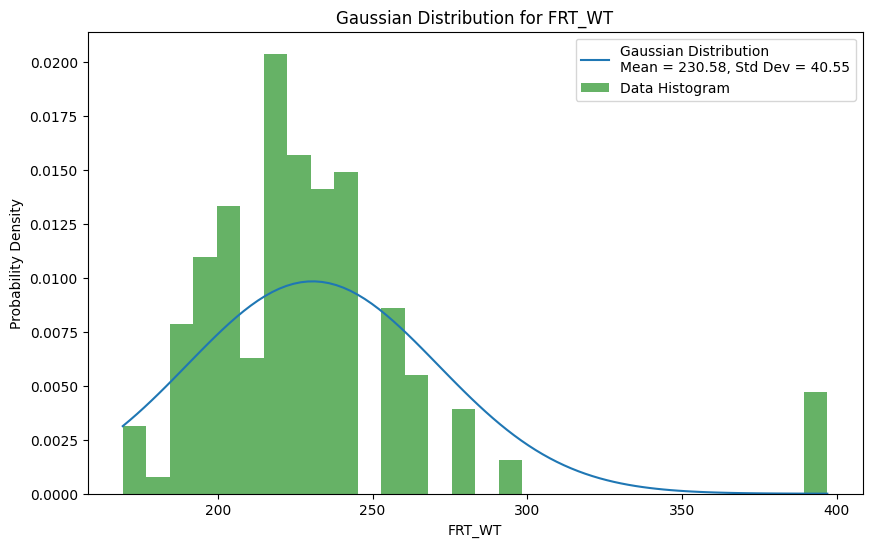

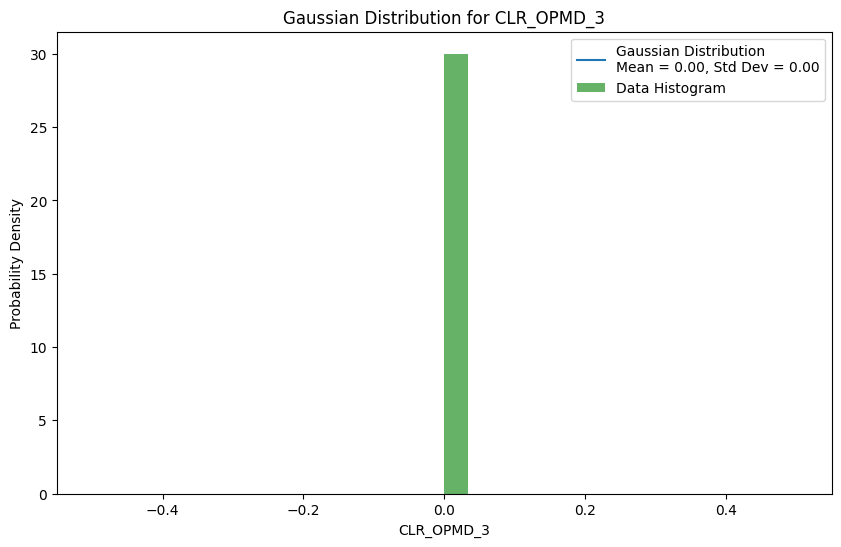

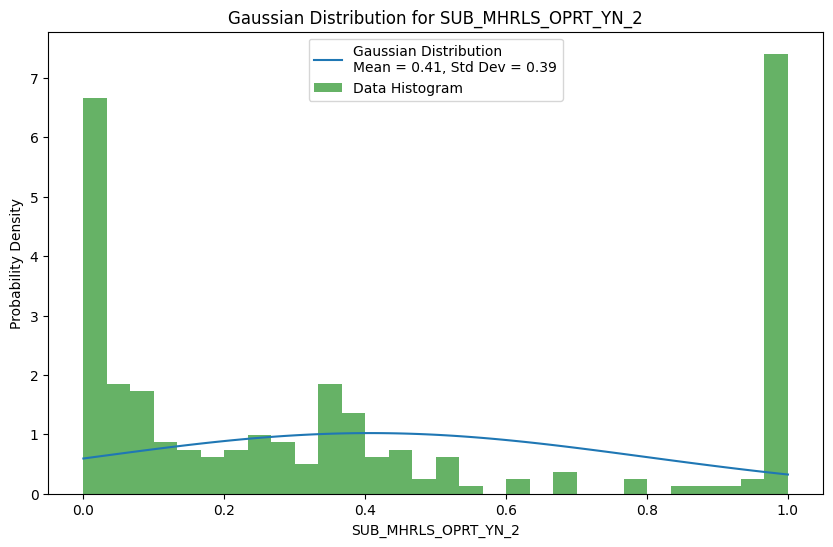

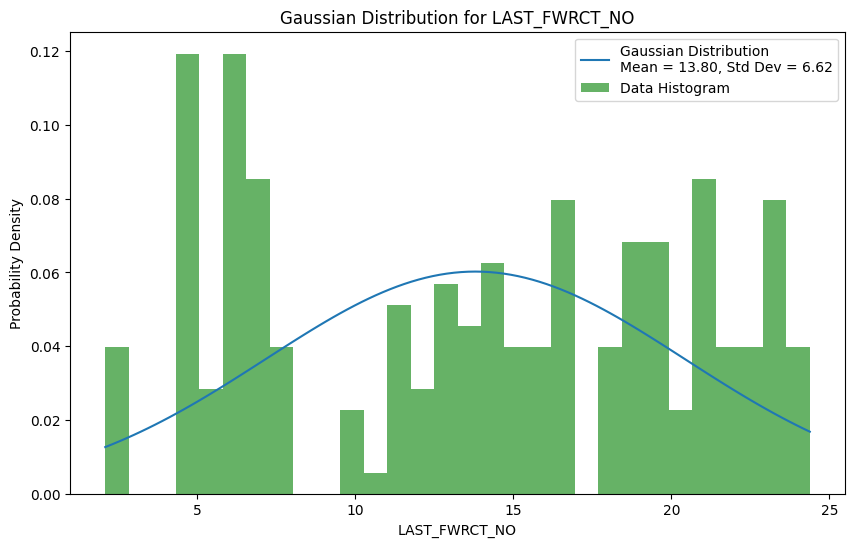

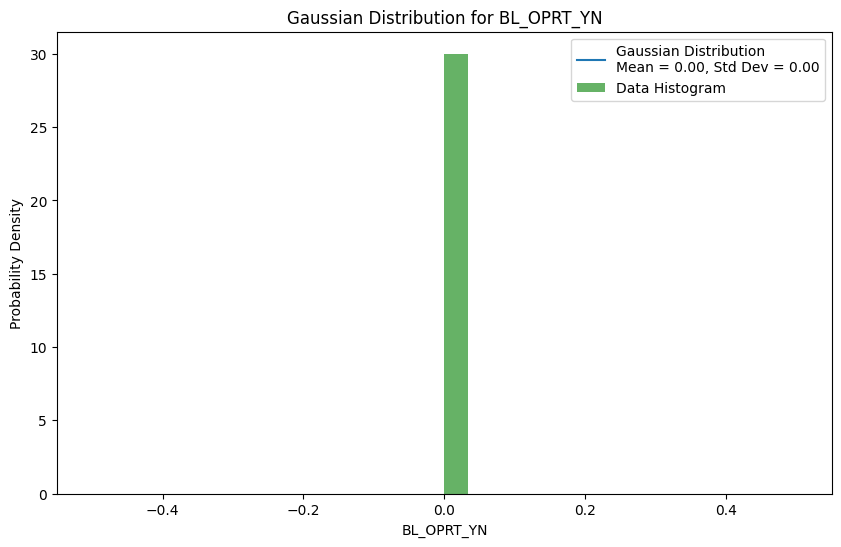

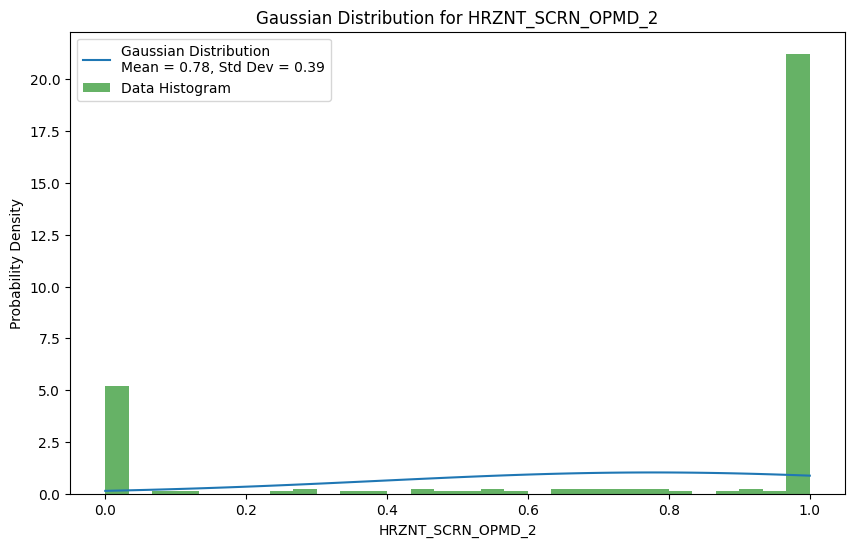

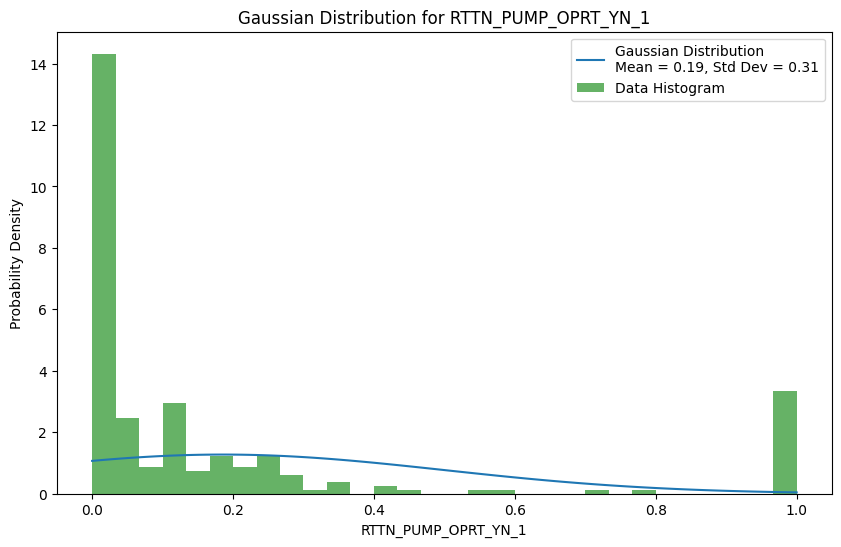

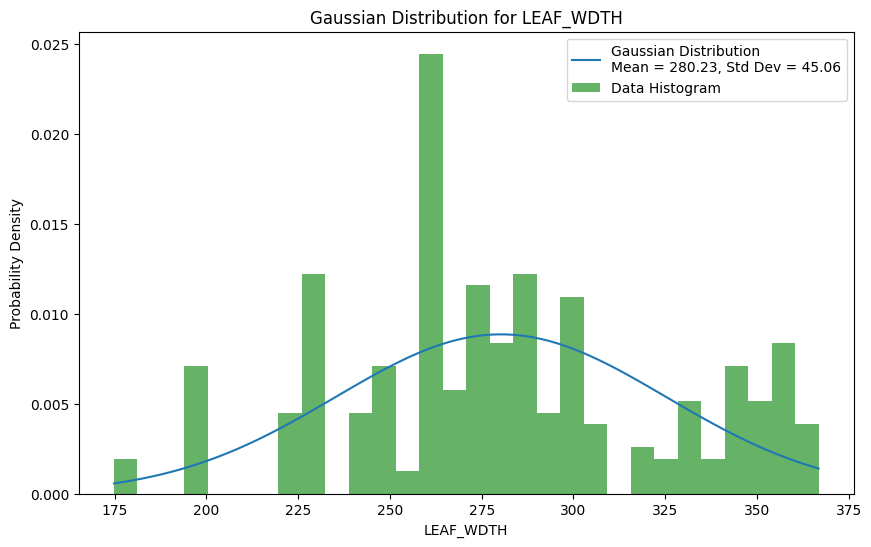

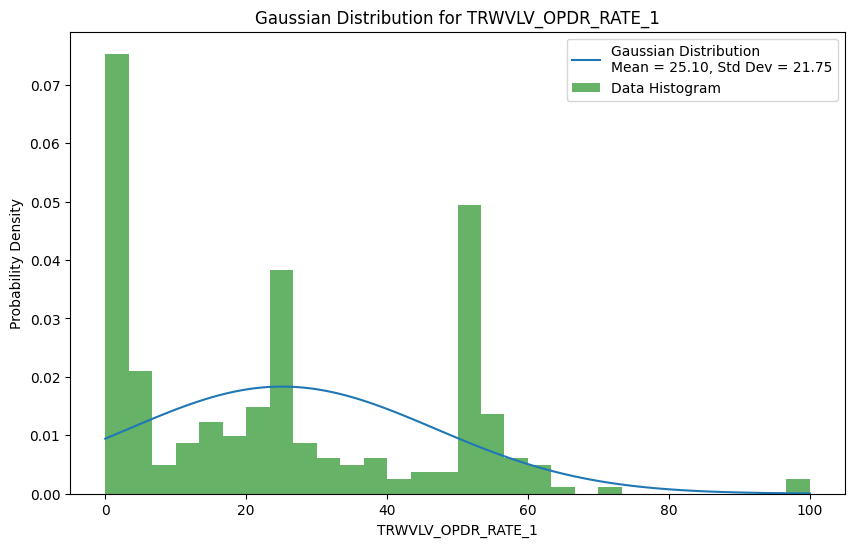

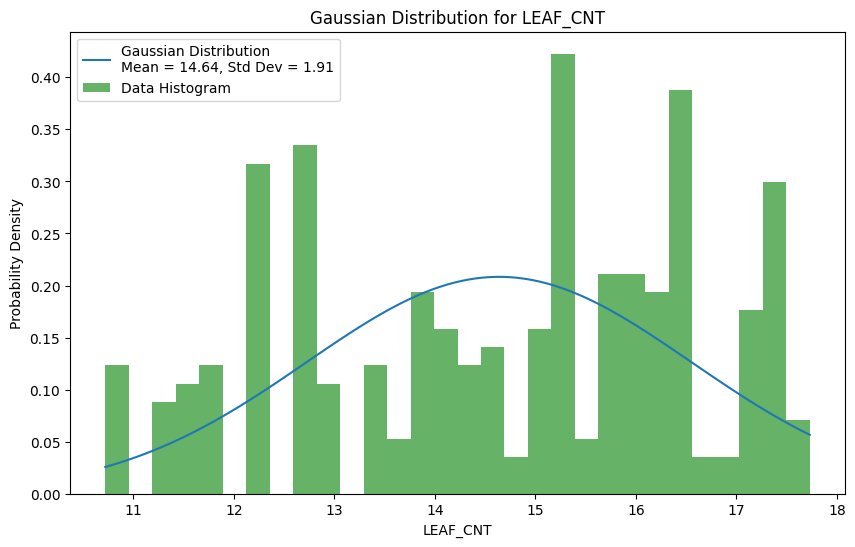

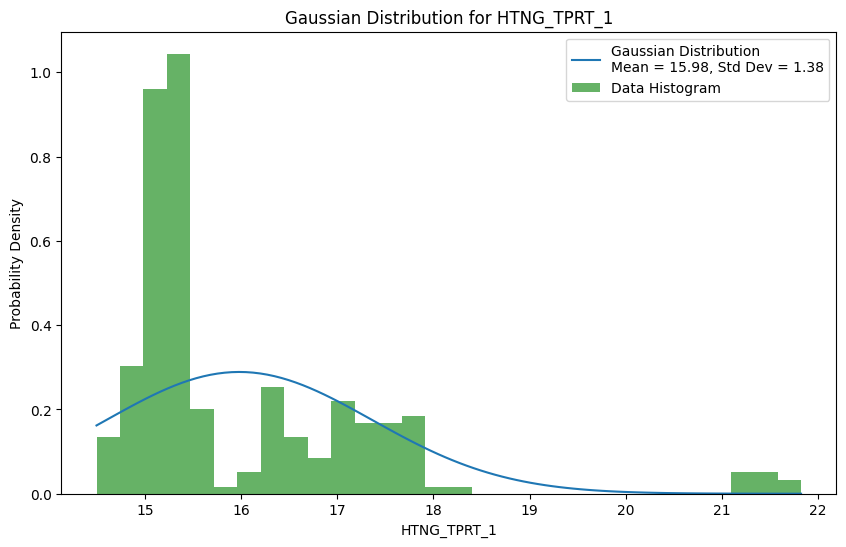

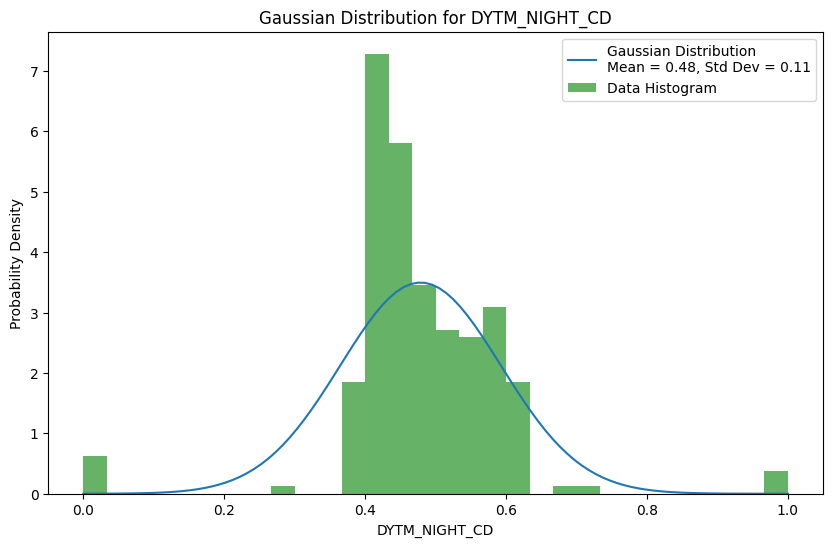

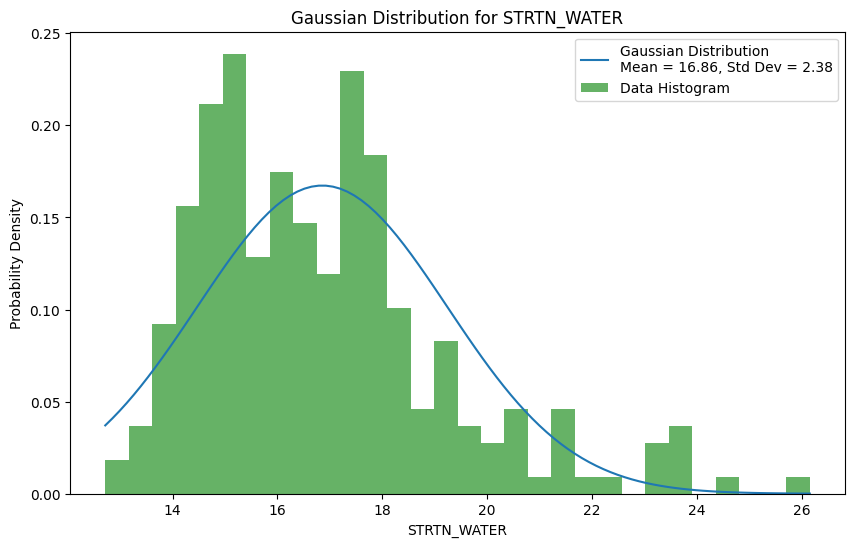

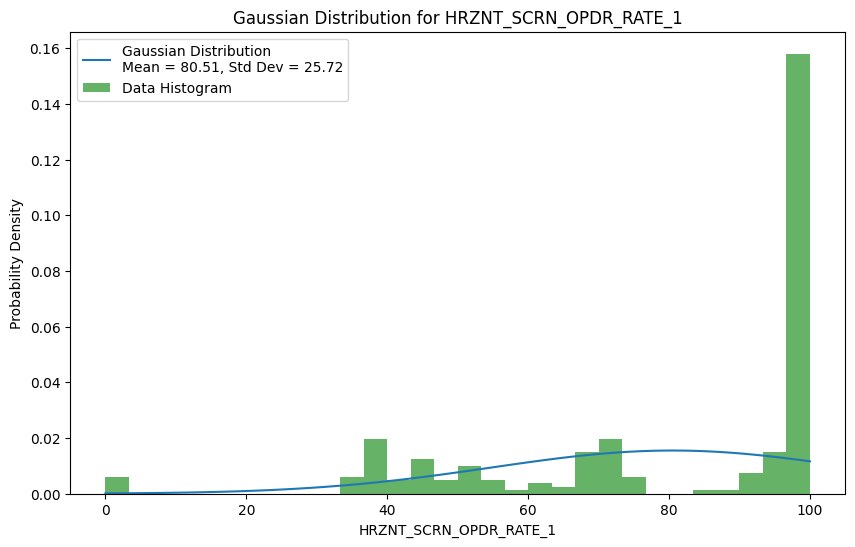

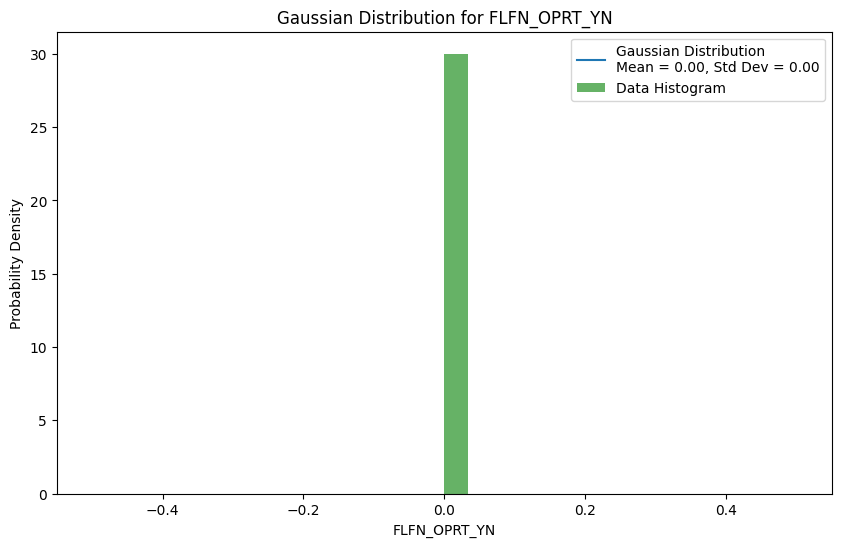

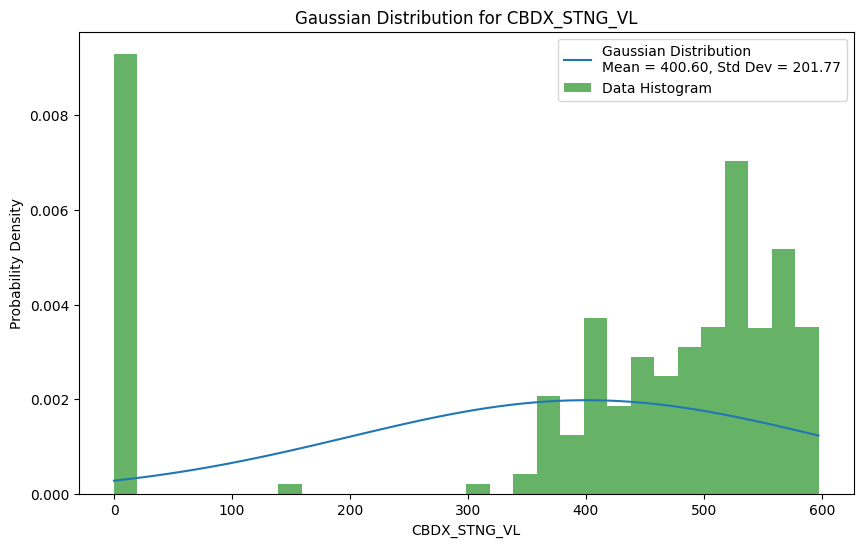

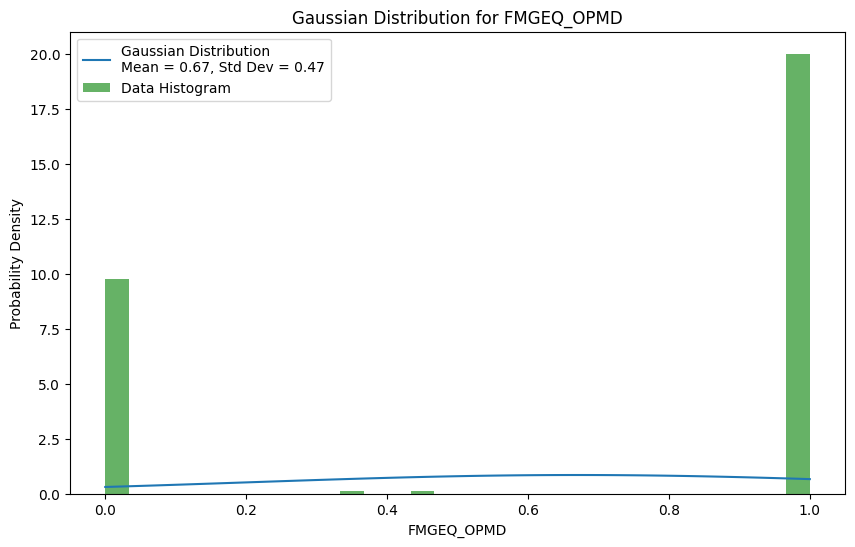

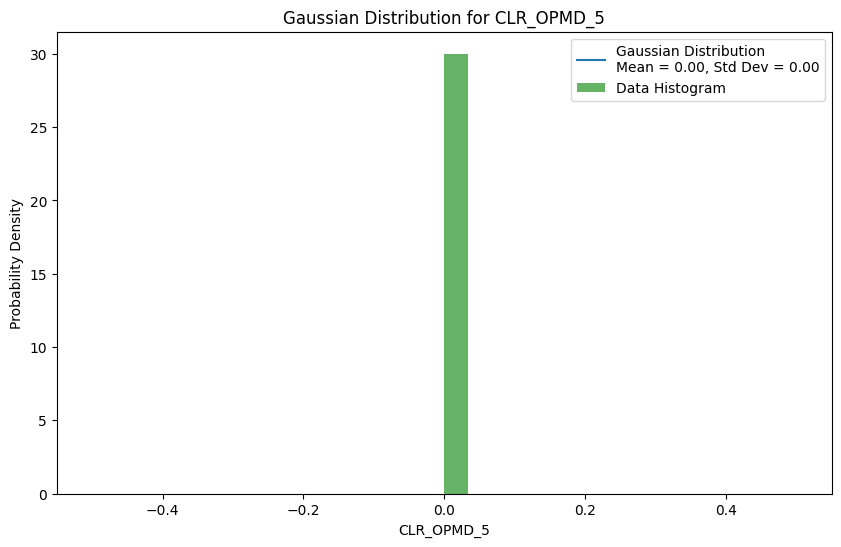

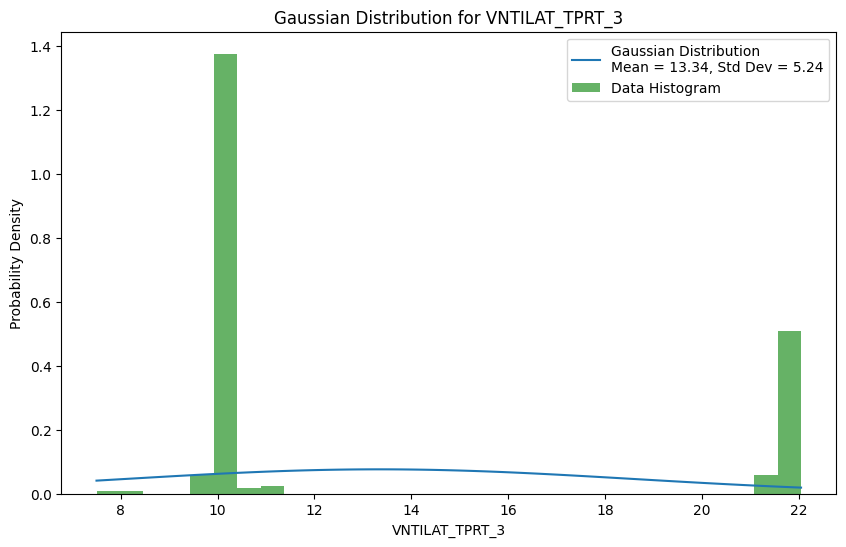

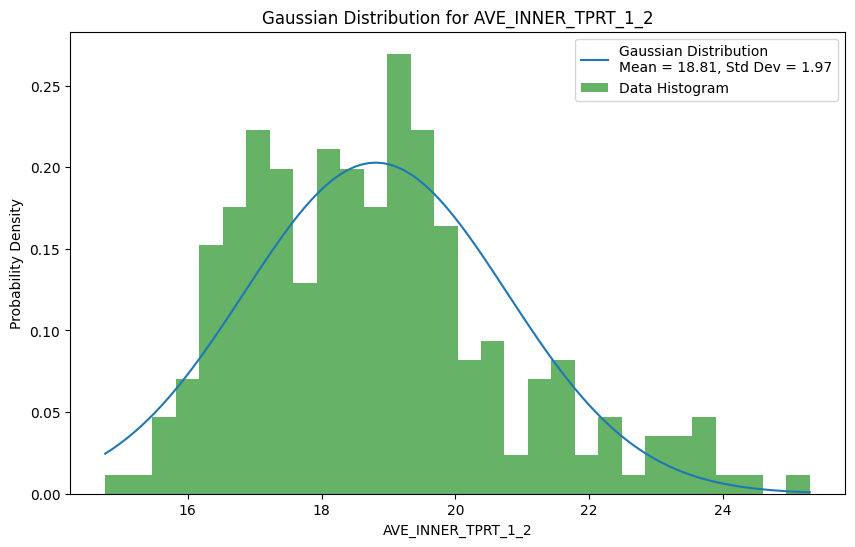

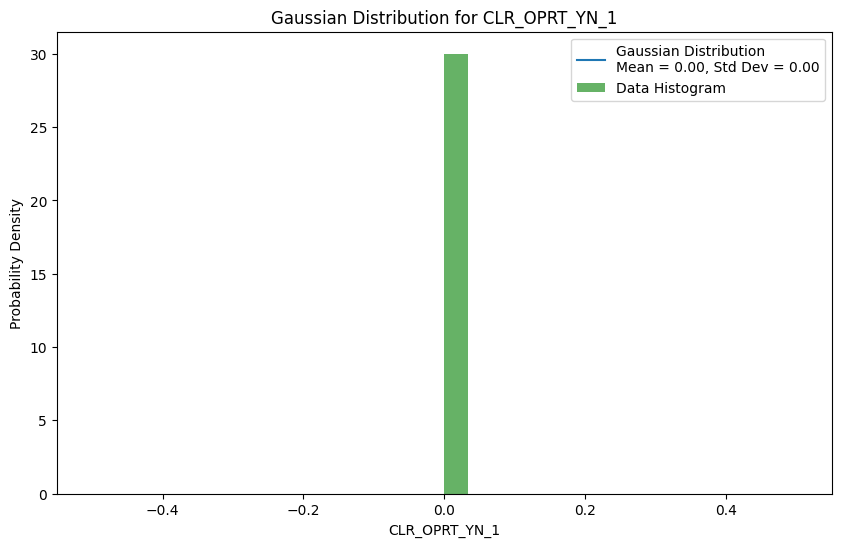

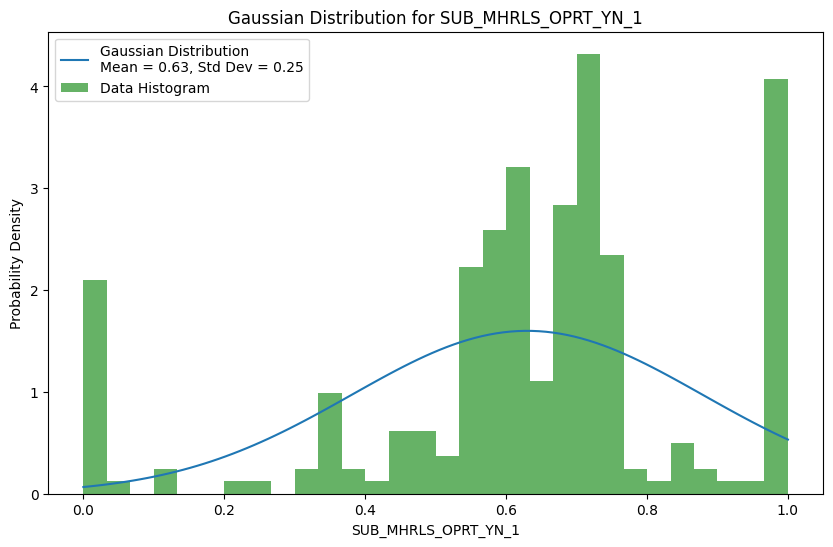

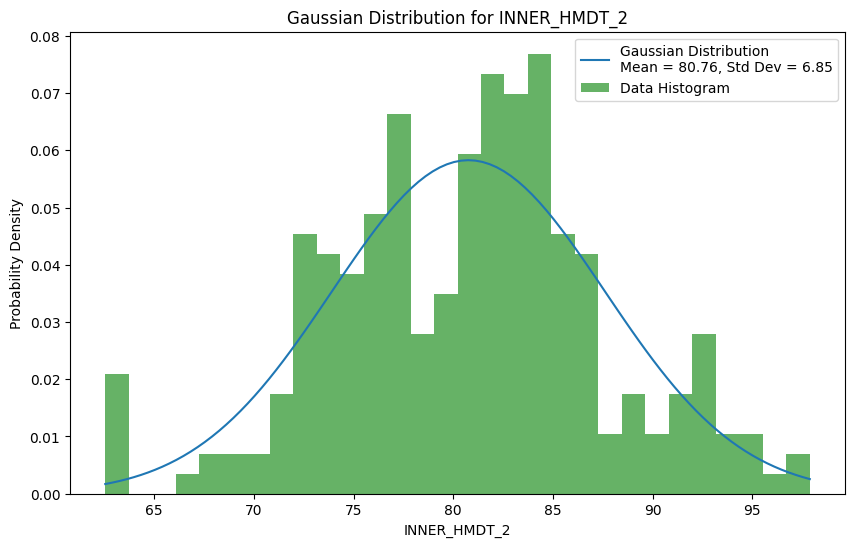

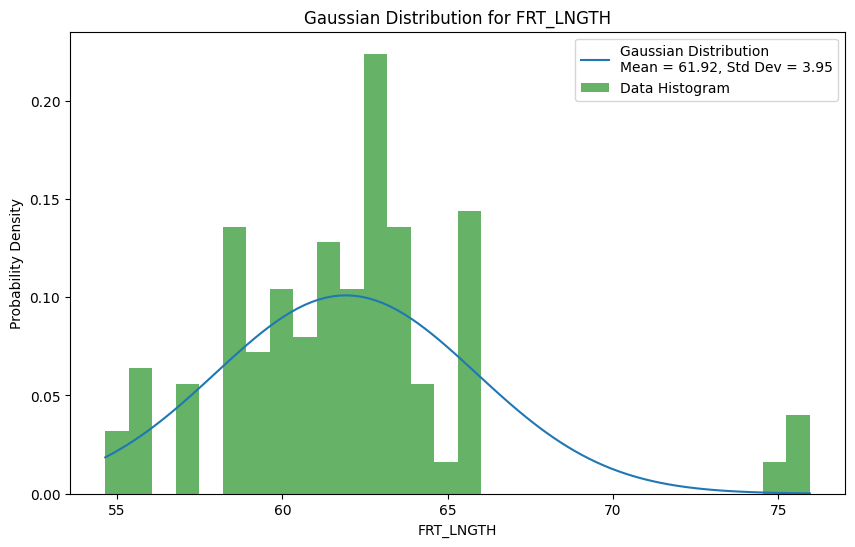

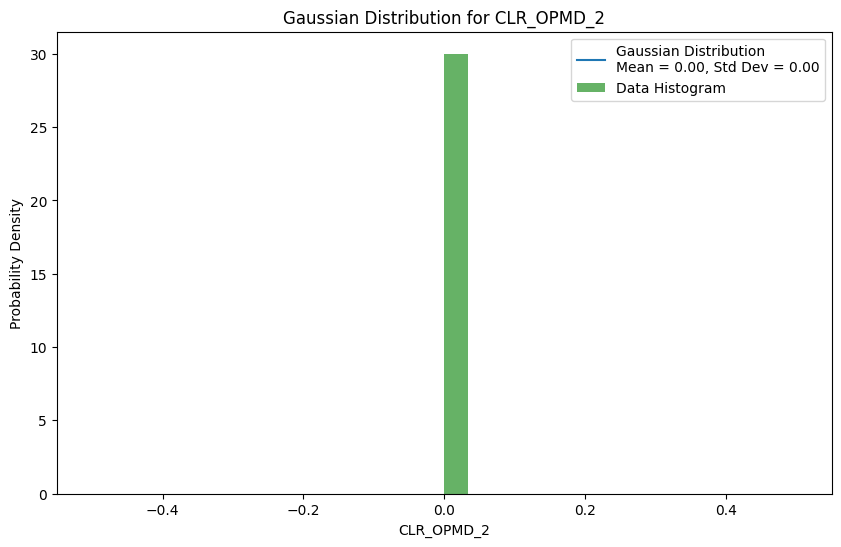

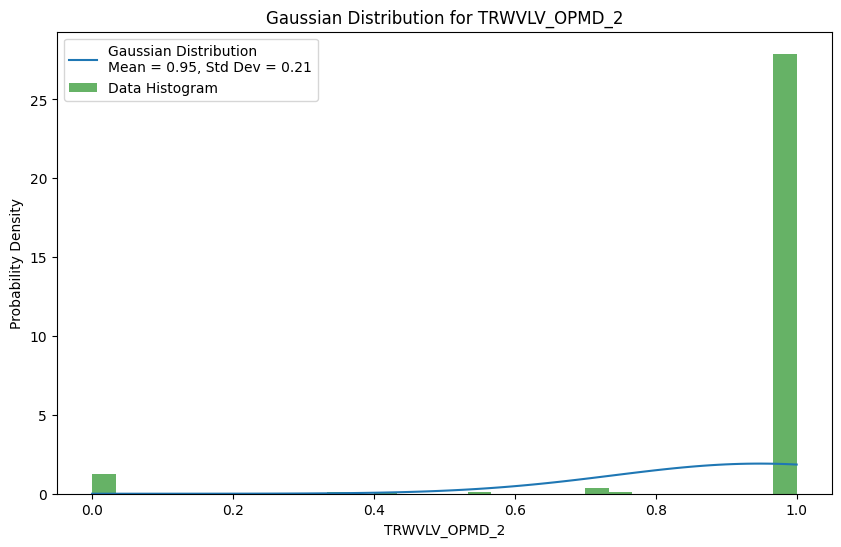

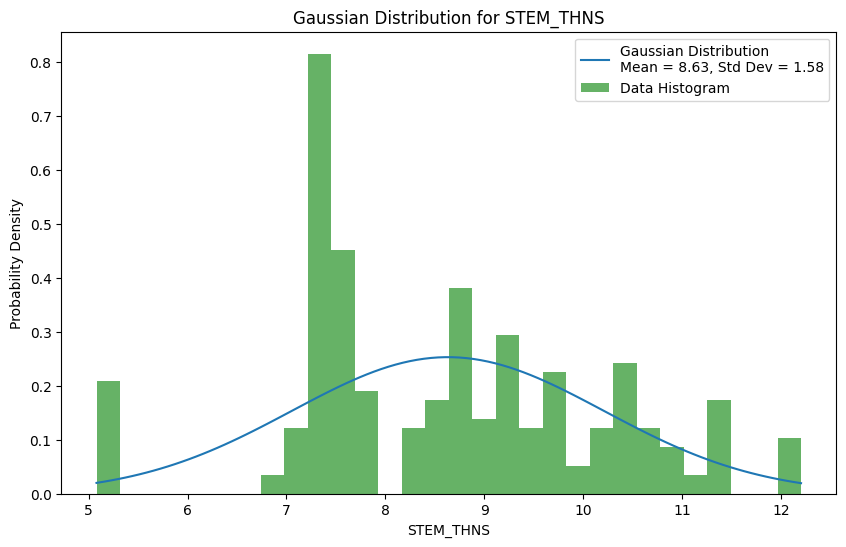

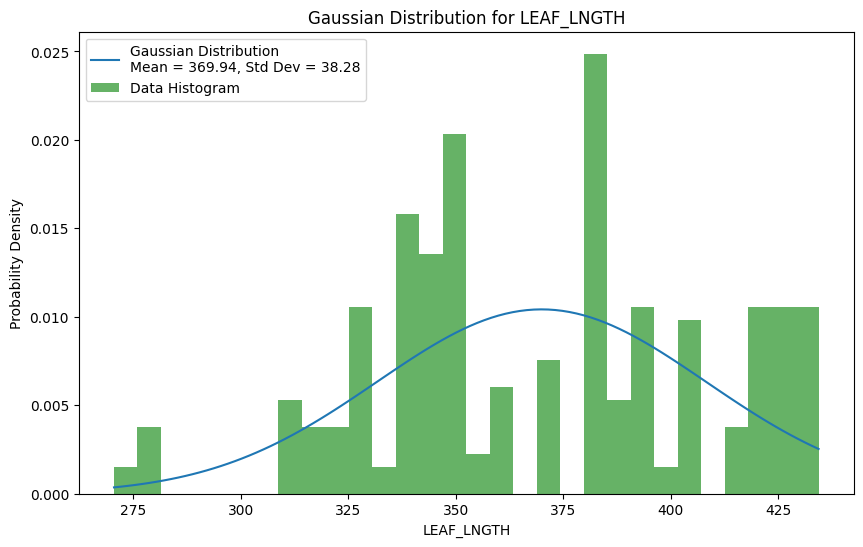

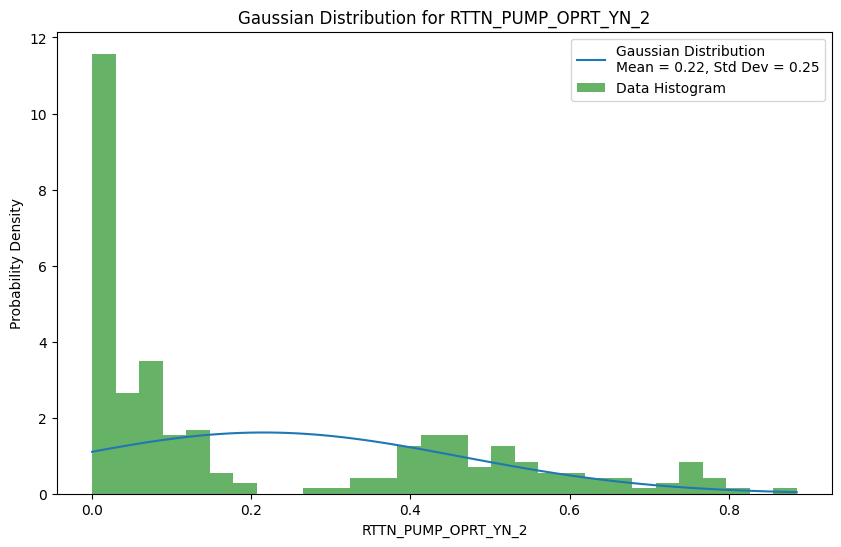

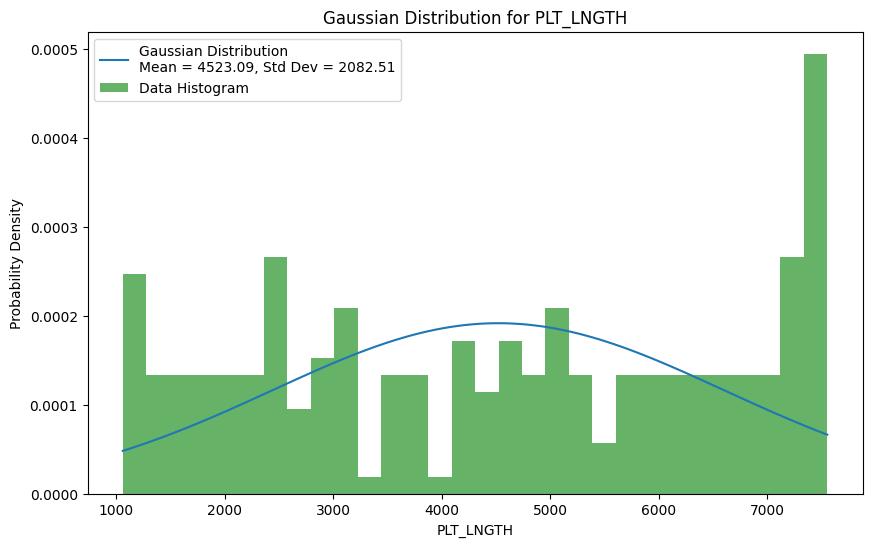

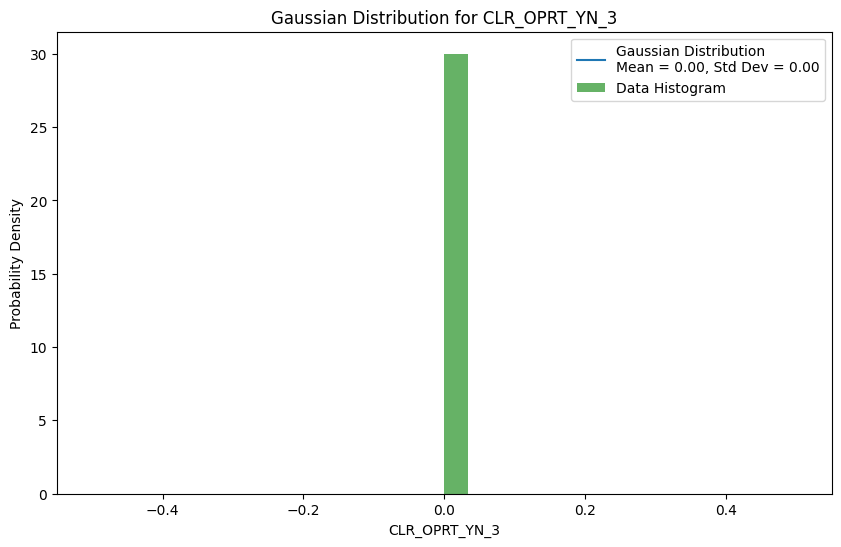

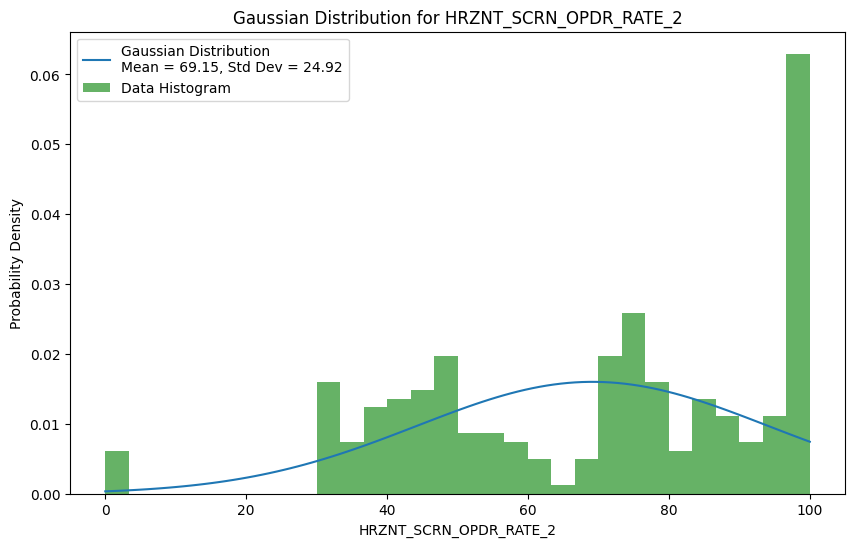

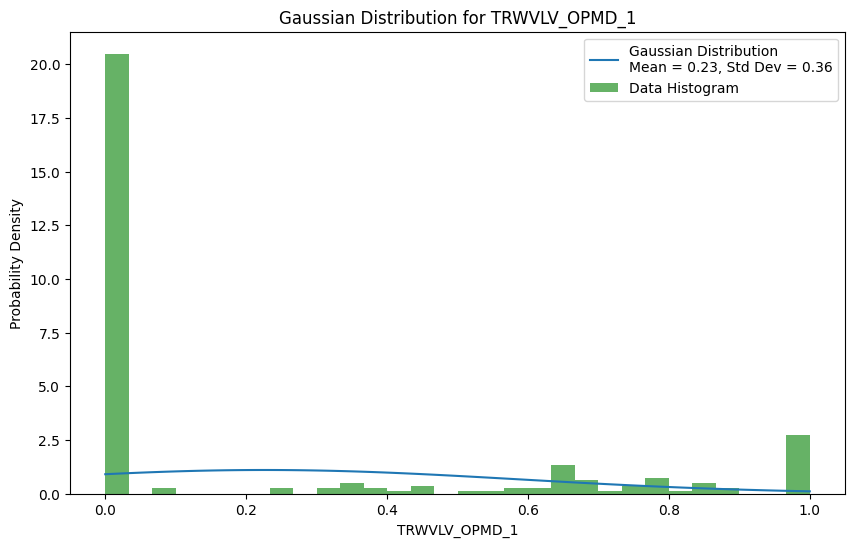

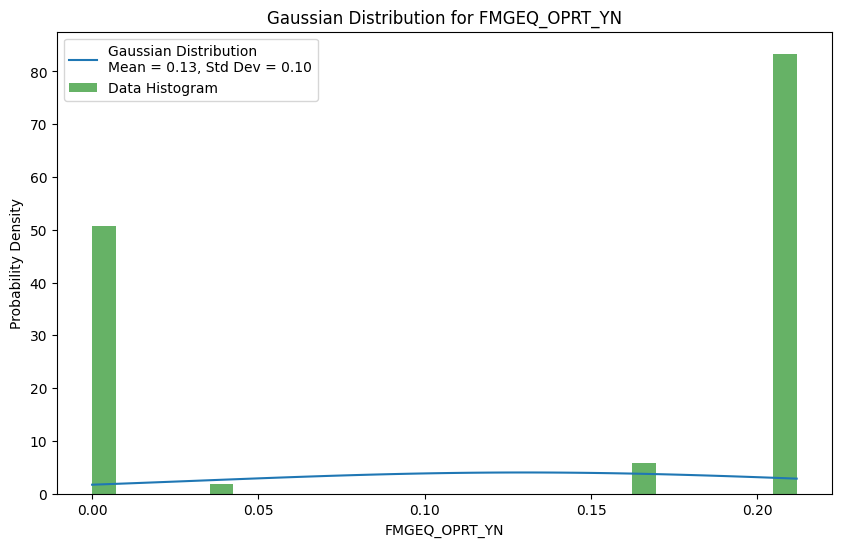

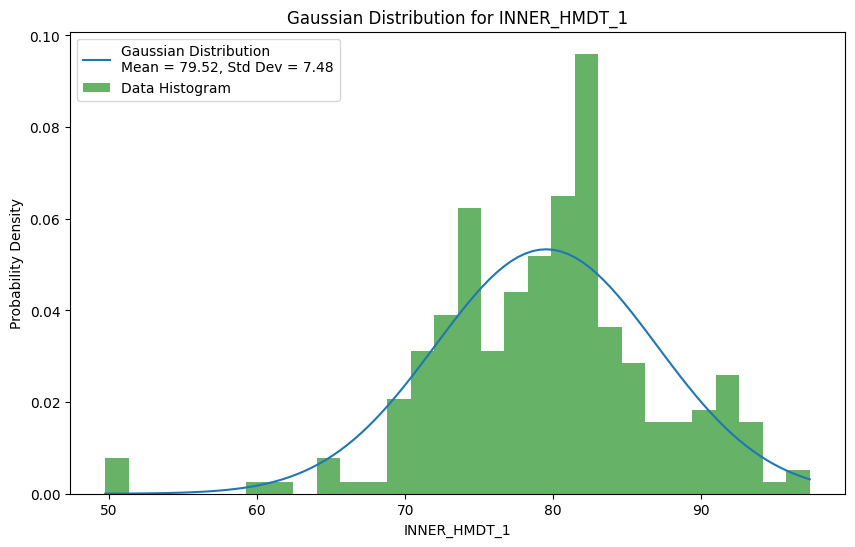

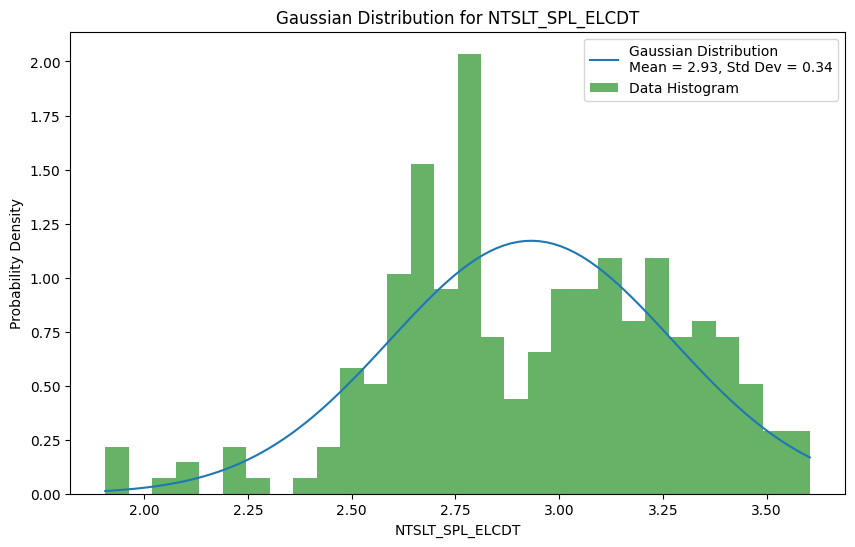

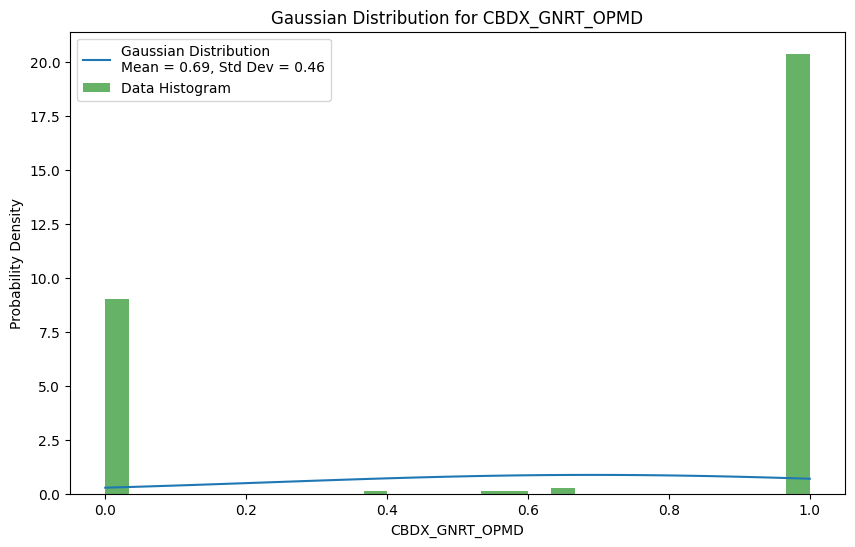

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 가우시안 분포를 시각화할 열 목록
columns = pdf.columns[1:]  # 첫 번째 열이 날짜이므로 제외

# 가우시안 분포 시각화
for column in columns:
    mean = means[column]
    std_dev = std_devs[column]
    
    # 데이터 범위 설정
    min_val = pdf[column].min()
    max_val = pdf[column].max()
    x = np.linspace(min_val, max_val, 100)
    
    # 가우시안 분포 계산
    y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'Gaussian Distribution\nMean = {mean:.2f}, Std Dev = {std_dev:.2f}')
    plt.hist(pdf[column], bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')
    plt.title(f'Gaussian Distribution for {column}')
    plt.xlabel(column)
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 가우시안 분포를 시각화할 열 목록
columns = pdf.columns[1:]  # 첫 번째 열이 날짜이므로 제외

# 가우시안 분포 시각화 및 파일 저장
for column in columns:
    mean = means[column]
    std_dev = std_devs[column]
    
    # 데이터 범위 설정
    min_val = pdf[column].min()
    max_val = pdf[column].max()
    x = np.linspace(min_val, max_val, 100)
    
    # 가우시안 분포 계산
    y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'Gaussian Distribution\nMean = {mean:.2f}, Std Dev = {std_dev:.2f}')
    plt.hist(pdf[column], bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')
    plt.title(f'Gaussian Distribution for {column}')
    plt.xlabel(column)
    plt.ylabel('Probability Density')
    plt.legend()
    
    # 그래프를 파일로 저장
    filename = f'gaussian_distribution_{column}.png'  # 또는 'jpg' 확장자를 사용
    plt.savefig(filename, format='png')  # format='jpg'로 변경 가능
    
    plt.close()  # 그래프를 닫아서 메모리 해제


/home/hadoop/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/hadoop/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
